In [9]:
import sys
sys.path.insert(1, '/home/dbreitman/CV_PS_denoising/py21cmdenoiser/')
import torch
#torch.cuda.set_device(0)
device = torch.device(f"cuda:0")
print(torch.cuda.memory_allocated() * 1e-6, 'Mb')
from denoiser import Denoiser
from properties import DenoiserConstants
from inputs import DenoiserInput
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from scipy.interpolate import interp1d

36.514303999999996 Mb


In [2]:
import h5py

In [3]:
new_db_path = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/'

In [4]:
HERA_zs = np.array([22.67333333, 16.755, 10.83666667, 10.4, 9.14571429, 7.8775, 6.89111111, 6.102])
wanted_zs = np.sort(np.concatenate((np.logspace(np.log10(5.3), np.log10(33), 32), HERA_zs)))
path2z = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/900/zs.npz'
redshifts = np.load(path2z)['zs']
here = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/'
path2z = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/900/zs.npz'
redshifts = np.load(path2z)['zs']

In [ ]:
for i in range(50):
    this_param = here+ str(i) + '/'
    this_param += 'FnP/'
    fnames = sorted(glob(this_param + '[0-9]*_*.npz'))
    all_tb = []
    for j in range(len(fnames)):
        lc_filepath = fnames[j]
        chunk_size = 200
        lc = np.load(lc_filepath)['Tb_fixed']
        chunk_indices = np.array(
            np.max(
                [
                    np.zeros_like(wanted_zs),
                    np.array([np.argmin(abs(redshifts - z)) for z in wanted_zs])
                    - chunk_size // 2,
                ],
                axis=0,
            ),
            dtype=np.int32,
        )
        global_tb=[]
        for ii in chunk_indices:
            start = ii
            end = ii + chunk_size
            if end > len(redshifts):
                # Shift the chunk back if it goes over the edge of the lc
                shift_it_back_by_a_few_bins = end - len(redshifts)
                start -= shift_it_back_by_a_few_bins
                end = len(redshifts)
            if start < 0:
                # Shift the chunk forward if it starts before the start of the lc
                end += -start
                start = 0
            chunk = lc[..., start:end]
            global_tb.append(np.mean(chunk))
        all_tb.append(global_tb)
    print(np.array(all_tb).shape)
    f = dict(np.load(glob(new_db_path + str(i) + '/FnP/*Aug_high_full.npz')[0]))
    f['global_Tb'] = np.array(all_tb)
    #np.savez(glob(new_db_path + str(i) + '/FnP/*Aug_high_full.npz')[0], **f)

In [23]:
with np.load('/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/Aug_db_50_thetas_nolog_final.npz') as f:
    kperp = np.array(f['kperp'])
    kpar = np.array(f['kpar'])
    param_mask = f['param_idx'] == 10 # Use param #10
    seeds = f['PS_2D_seeds'][param_mask]
    Nmodes = f['Nmodes']
    mean = f['PS_2D_means'][param_mask]
    tb = f['Tb'][param_mask]
    xhi = f['xHI'][param_mask]
    fnames = f['fnames'][param_mask]

In [27]:
fnames[:45]

array(['/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/10_5512574859.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/10_6315242569.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/10_8324650108.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/10_836553599_xHI.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/110_1064957576.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/110_1086509651.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/110_1140894559.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/110_1181224408.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/110_1210662443.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/110_1317494284.npz',
       '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/10/110_1341176962.npz',
       '/projects/cosm

In [6]:
with np.load(path + 'Aug_db_50_thetas_nolog_final.npz') as f:
    z_idxs = [0,1,2,3,4,5,6,7,8,9,11,13,19,23,30,39]
    means = f['PS_2D_means'][:,z_idxs,...]
    print(means.shape)
    print(len(np.unique(f['param_idx'])))

NameError: name 'path' is not defined

In [5]:
path = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/'
plots_path = '/home/dbreitman/CV_PS_denoising/cAE_wTbz/Aug/score_based/results2/Test/'
with np.load(path + 'Aug_FnP_db_final.npz') as f:
    zs = f['redshifts']
    redshifts = f['redshifts']
    kperp = f['kperp']
    kpar = f['kpar']
    param_idx_fnp = f['param_idx']
    fnp_xhis = f['xHI']
    Nmodes = f['Nmodes']
with np.load(path + 'Aug_db_50_thetas_nolog_final.npz') as f:
    z_idxs = [0,1,2,3,4,5,6,7,8,9,11,13,18,19,23,26,30,32,38,39]
    mean = f['PS_2D_means'][:,z_idxs,...]
    seeds = f['PS_2D_seeds'][:,z_idxs,...]
    param_idx = f['param_idx']
    Tbs = f['Tb'][:,z_idxs,...]
    xHI = f['xHI'][:,z_idxs,...]
    modes = f['Nmodes']

# load test sampled from denoiser:
pars = np.repeat(param_idx, len(z_idxs))
zzs = np.array(list(redshifts[z_idxs])* seeds.shape[0])
noisy_samples = np.copy(seeds)
xHIs = np.copy(xHI)
N=10000
noisy_samples = noisy_samples.reshape(((np.prod(seeds.shape[:2]),) + seeds.shape[-2:]))
mask = np.mean(noisy_samples, axis = (-1,-2)) > 1e-2
xHIs = xHIs.reshape(((np.prod(seeds.shape[:2]),)))[mask]
noisy_samples = noisy_samples[mask]
pars = pars[mask]
means = np.copy(mean).reshape(((np.prod(seeds.shape[:2]),) + seeds.shape[-2:]))[mask]
zzs = zzs[mask]
np.random.seed(0)
rand = np.arange(noisy_samples.shape[0])
np.random.shuffle(rand)

all_mu_fes = []
all_mu_abserrs = []
nevals = len(glob(plots_path+'testset_pred_[0-9]*.npz'))
print(nevals)
all_xHIs = []
all_zs = []
all_sv_fe = []
all_sv_abserr = []
all_noisy = []
all_params = []
all_pred = []
all_truth = []
for idx in range(nevals):
    idxs = rand[N*idx:N*(idx+1)]
    truth = means[idxs]
    truth[truth<1e-2] = 1e-2
    try:
        pred0 = dict(np.load(plots_path+f'testset_pred_{idx}.npz'))
    except:
        try:
            pred0 = dict(np.load(plots_path+f'testset_pred_{idx}.npz'))
        except:
            pred0 = dict(np.load(plots_path+f'testset_pred_{idx}.npz'))
    current_len = pred0['ypred'].shape[0]
    noisy = noisy_samples[idxs][:current_len]
    params = pars[idxs][:current_len]
    all_params.extend(params)
    all_noisy.extend(noisy)
    zss = zzs[idxs][:current_len]
    truth = truth[:current_len]
    mu_fe = abs((np.median(pred0['ypred'], axis = 1) - truth)/truth)*100.#, axis = (-1,-2))
    abs_err = abs(np.median(pred0['ypred'], axis = 1) - truth)
    m = np.isnan(np.nanmean(abs((np.median(pred0['ypred'], axis = 1) - truth)), axis = (-1,-2)))
    all_mu_fes.extend(mu_fe[~m])
    all_xHIs.extend(xHIs[idxs][:current_len][~m])
    all_mu_abserrs.extend(abs_err[~m])
    all_zs.extend(zss[~m])
    mu_fee = abs((noisy - truth)/truth)*100.#, axis = (-1,-2))
    abserr = abs(noisy - truth)
    all_truth.extend(truth)
    all_pred.extend(np.median(pred0['ypred'], axis = 1))
    all_sv_fe.extend(mu_fee)
    all_sv_abserr.extend(abserr)
all_mu_fes=np.array(all_mu_fes)
all_xHIs = np.array(all_xHIs)
all_mu_abserrs = np.array(all_mu_abserrs)
all_zs = np.array(all_zs)
all_sv_fe = np.array(all_sv_fe)
all_sv_abserr = np.array(all_sv_abserr)
all_noisy = np.array(all_noisy)
all_params = np.array(all_params)
all_truth = np.array(all_truth)
all_pred = np.array(all_pred)

3



KeyboardInterrupt



In [10]:
all_mu_fes.shape

(21626, 32, 16)

In [47]:
xHI_bin_edges = [10**(-2.5)]
for i in range(25):
    i+=1
    xHI_bin_edges.append(xHI_bin_edges[i-1]*1.2+10**(-2.5))
print(xHI_bin_edges)

[0.0031622776601683794, 0.006957010852370434, 0.0115106906830129, 0.01697510647978386, 0.02353240543590901, 0.03140116418325919, 0.0408436746800794, 0.052174687276263655, 0.06577190239168476, 0.08208856053019009, 0.10166855029639649, 0.12516453801584415, 0.15335972327918135, 0.18719394559518598, 0.22779501237439156, 0.2765162925094382, 0.3349818286714942, 0.4051404720659614, 0.489330844139322, 0.5903592906273548, 0.7115934264129942, 0.8570743893557614, 1.031651544887082, 1.2411441315246667, 1.4925352354897683, 1.7942045602478902]


In [26]:
xHI_bin_edges = np.linspace(0.01, 1., 31)
xHI_bin_centers=(xHI_bin_edges[1:] + xHI_bin_edges[:-1]) / 2
percs = []
n = []
for i in range(len(xHI_bin_edges)-1):
    m = np.logical_and(all_xHIs >= xHI_bin_edges[i], all_xHIs < xHI_bin_edges[i+1])
    percs.append(np.percentile(all_mu_fes[m], [2.5,16,50,84,97.5], axis = 0))
    n.append(np.sum(m))
percs = np.array(percs)

In [12]:
xHI_bin_centers

array([0.0265, 0.0595, 0.0925, 0.1255, 0.1585, 0.1915, 0.2245, 0.2575,
       0.2905, 0.3235, 0.3565, 0.3895, 0.4225, 0.4555, 0.4885, 0.5215,
       0.5545, 0.5875, 0.6205, 0.6535, 0.6865, 0.7195, 0.7525, 0.7855,
       0.8185, 0.8515, 0.8845, 0.9175, 0.9505, 0.9835])

In [27]:
percs.shape

(30, 5, 32, 16)

In [20]:
one_sigma = np.nanmean([percs[:,2] - percs[:,1], percs[:,3] - percs[:,2]], axis = 0)

In [21]:
one_sigma.shape

(30,)

In [7]:
from denoiser import Denoiser

In [10]:
denoiser = Denoiser(condition=False,Nsamples=100)
print(torch.cuda.memory_allocated(device)*1e-6, 'Mb')

38.349312 Mb


In [10]:
#In nvidia-smi, before first denoiser call, it's 857 MiB per process, but then some processed become 3Gb??

0.8436418560000001

In [15]:
for i in range(1):
    denoiser_output = denoiser.predict(seeds[5,...], 
                                        kperp, kpar)
    print(torch.cuda.memory_allocated(device)*1e-6, 'Mb')
mean_estimate = denoiser_output.mean_delta
delta_err = denoiser_output.denoiser_median_on_test_mean # avg denoiser error on the test set mean in mK^2 at the input xHI values 
kperp = denoiser_output.kperp
kpar = denoiser_output.kpar

Sampling :   0%|          | 0/40 [00:00<?, ?it/s]

46.868992 Mb


In [13]:
mean_estimate.shape, seeds.shape, mean.shape

((10030, 20, 32, 16), (10030, 20, 32, 16))

0 5.0 0.5243290081620217 1.3613124608993528 2.3252504


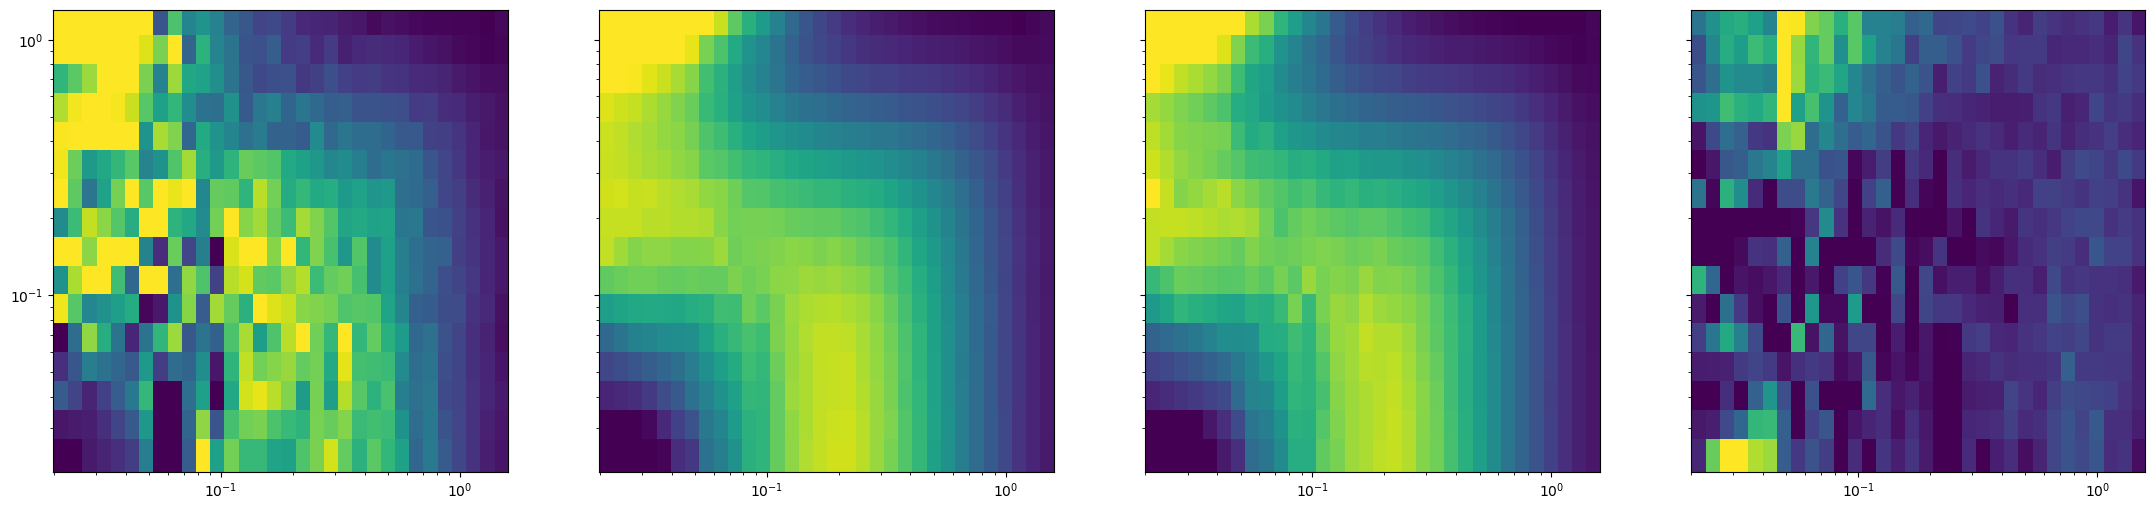

1 5.0027933 1.2965799570083618 3.0131443500518795 1.8021137


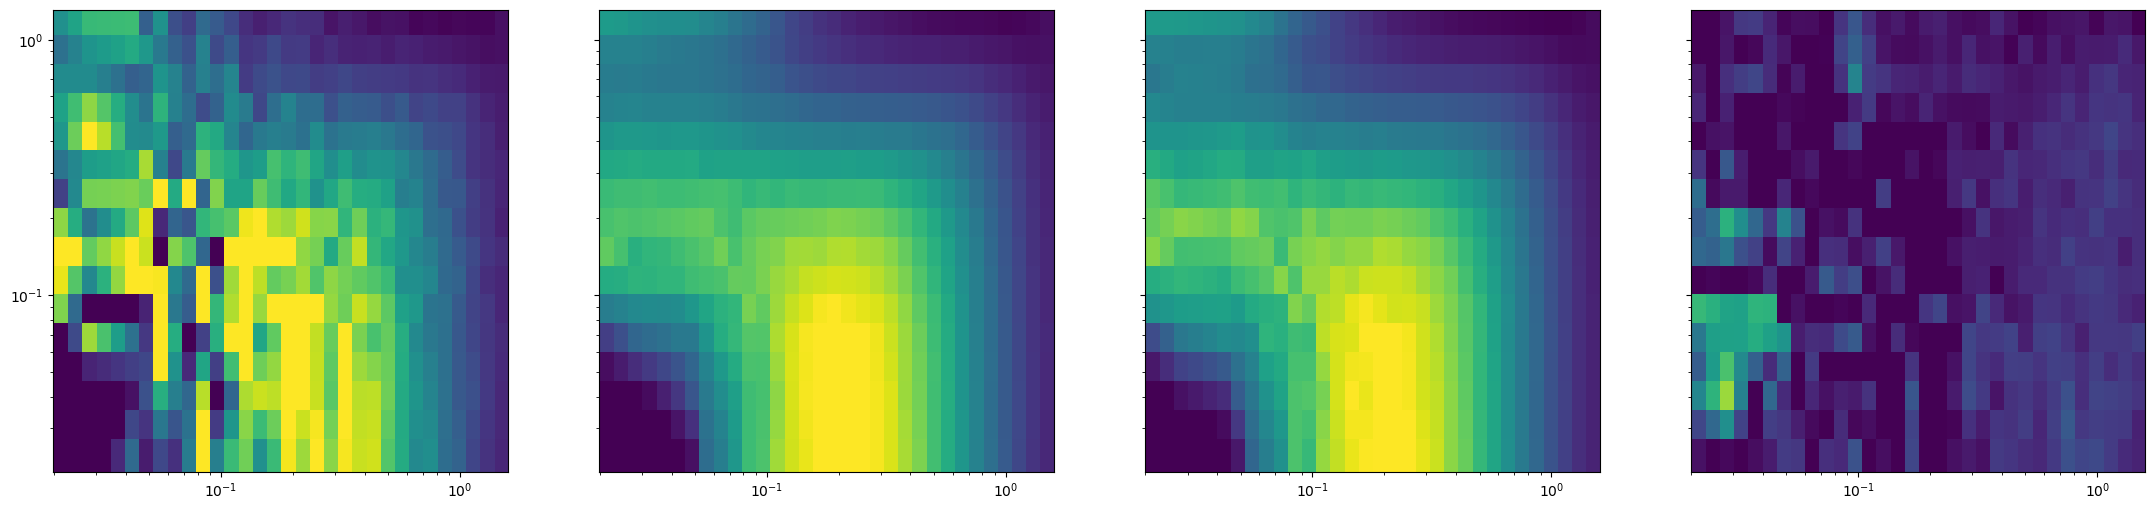

2 5.0055885 1.771037444472313 5.313216972351074 1.3860905


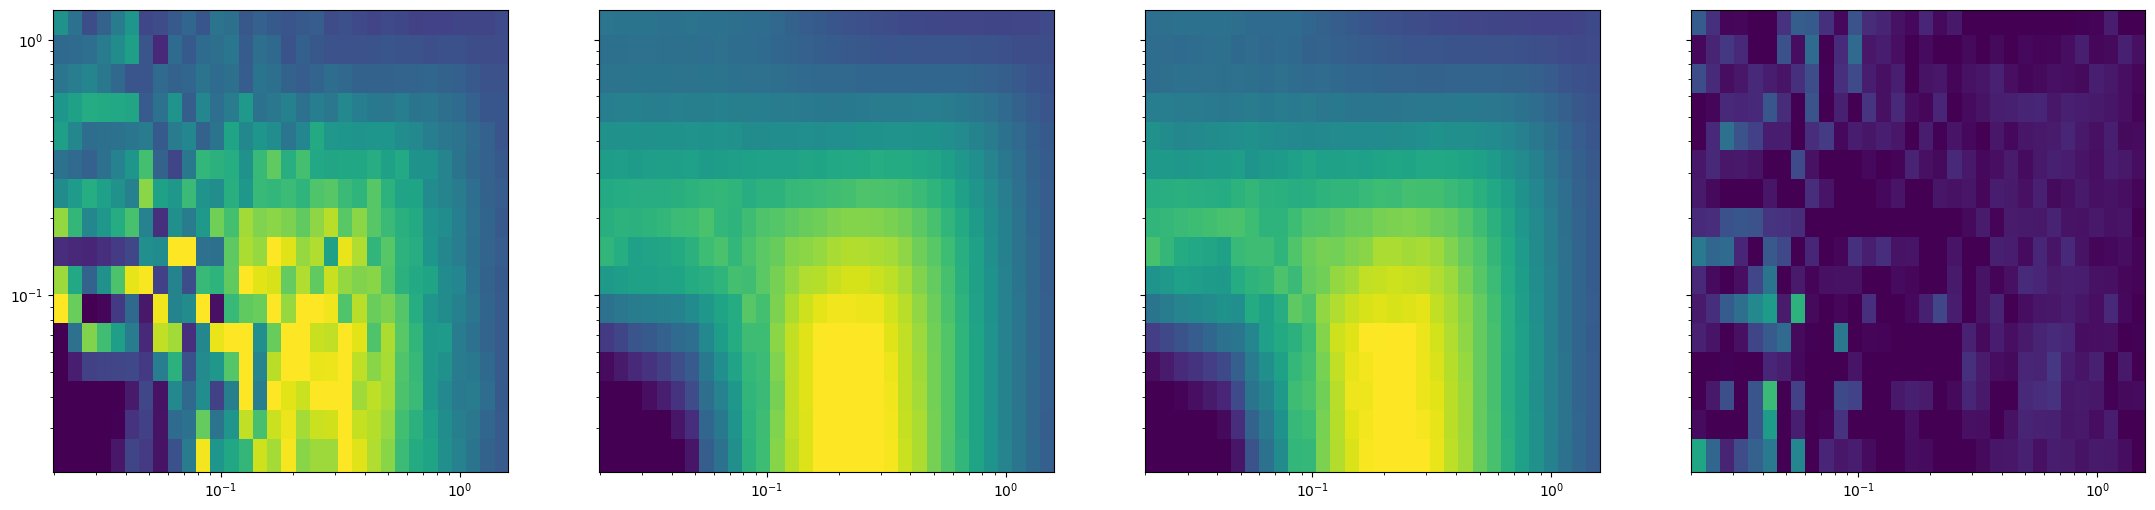

3 5.0083857 1.827839145064354 6.230466377735138 0.5367577


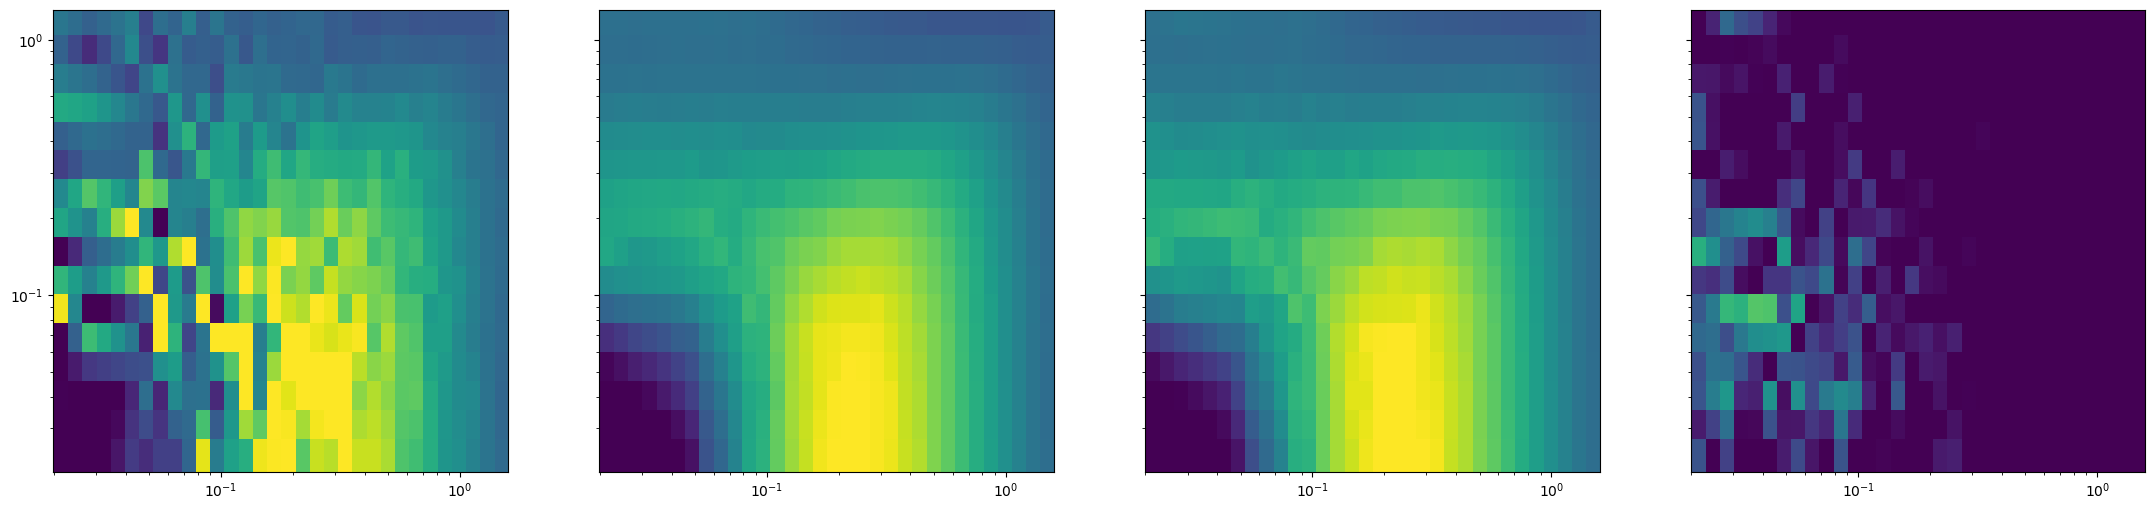

4 5.0111847 1.7752757370471954 7.509781122207642 2.2259002


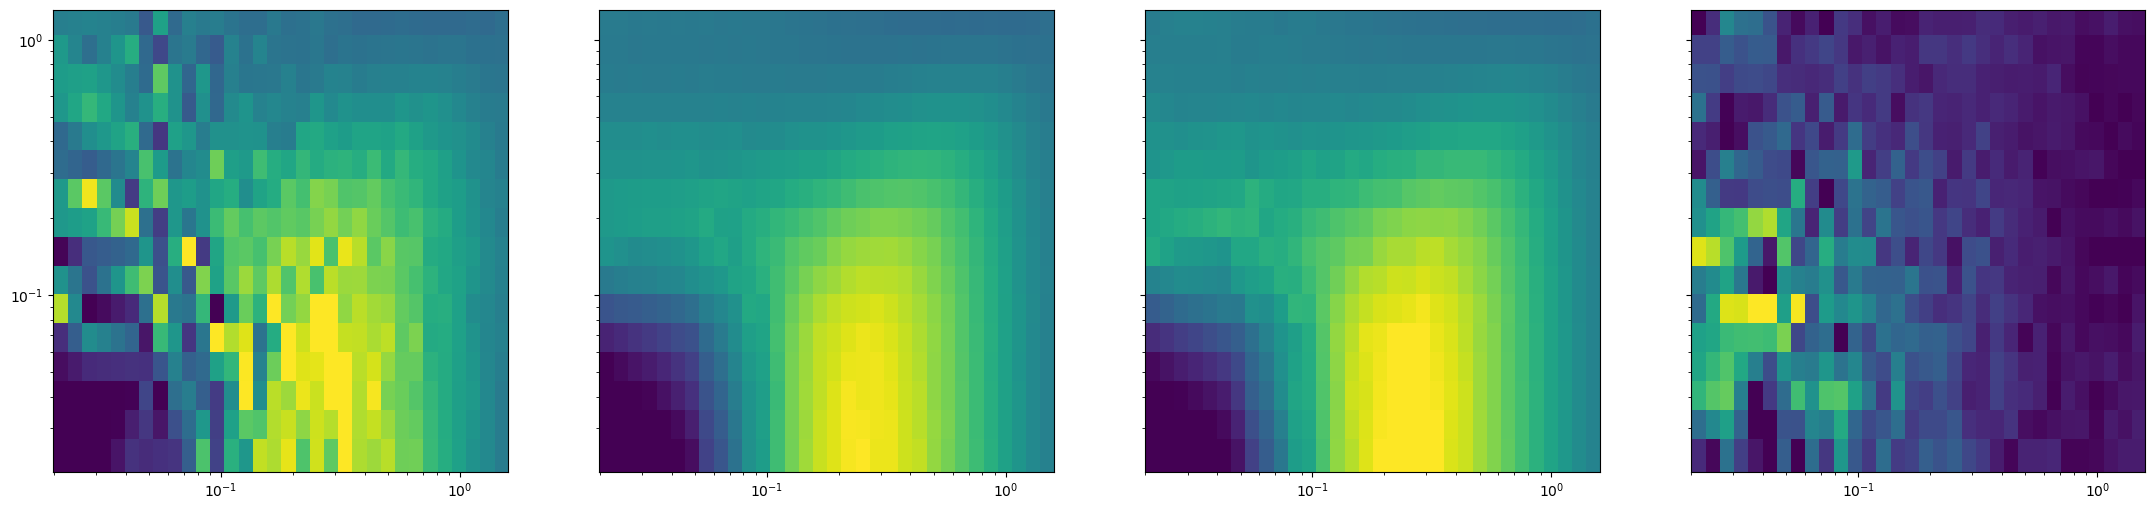

5 5.0139856 1.3820447355508805 8.774269676208496 0.6691607


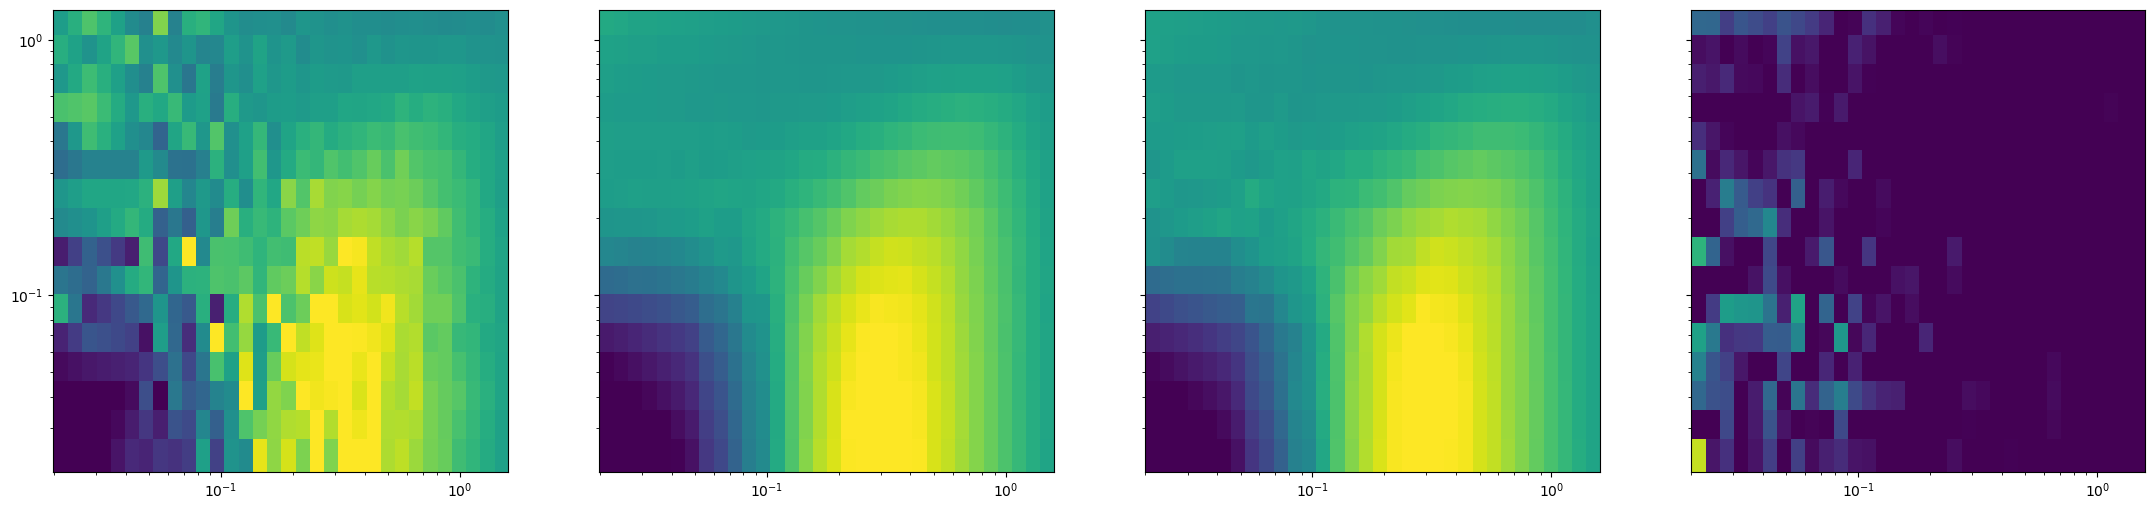

6 5.0167885 1.1611475199460983 8.990009093284607 0.6470822


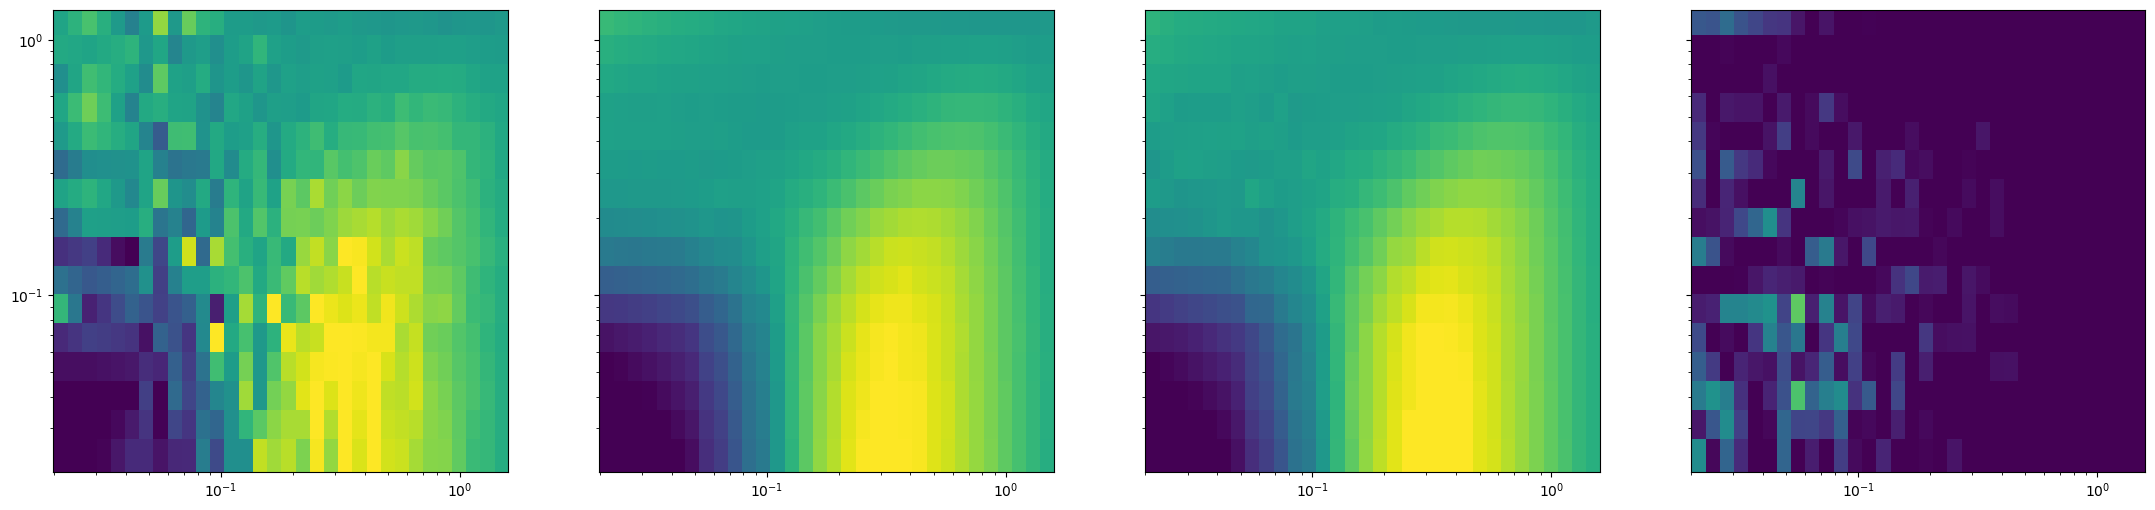

7 5.0195937 0.8638795793056488 8.760868835449218 1.6842787


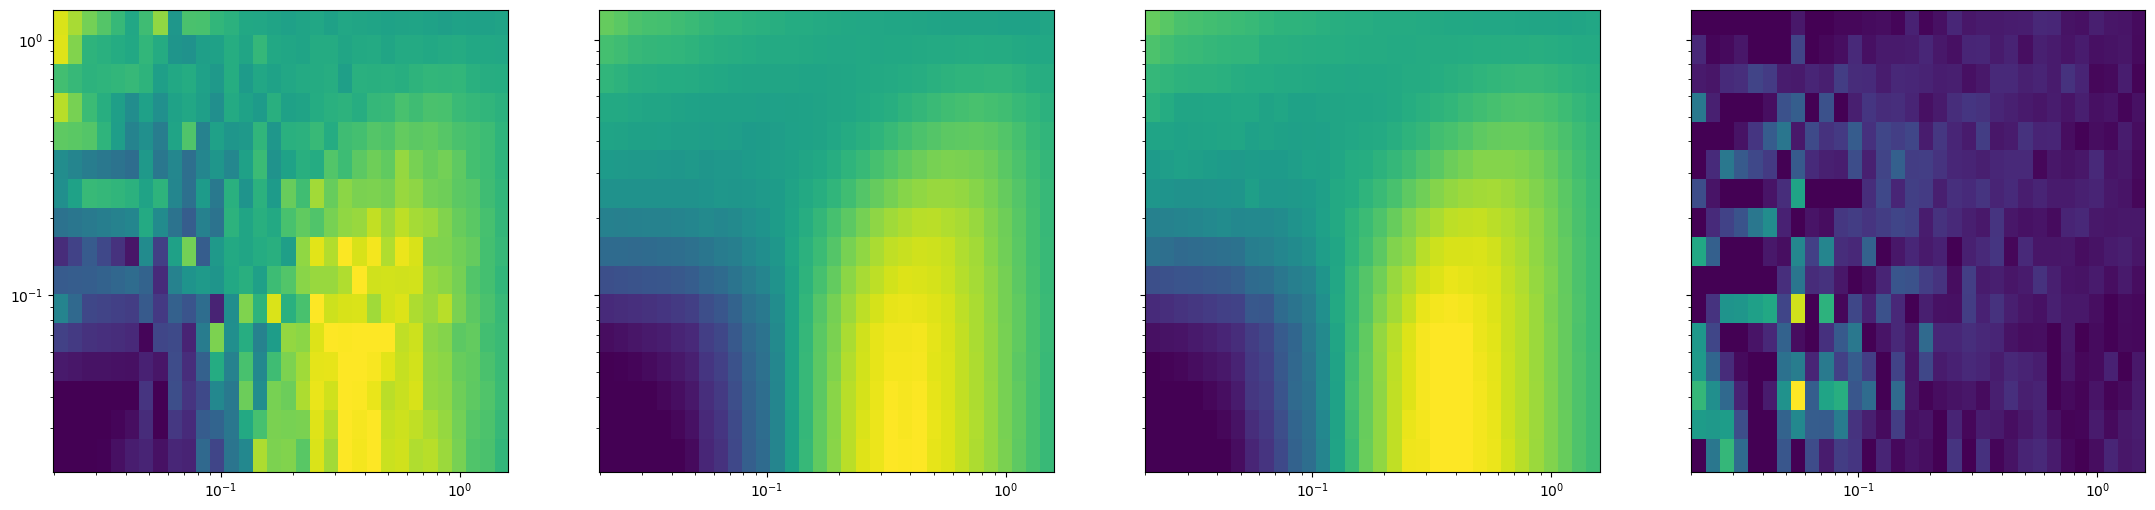

8 5.0224004 0.3590238943696022 7.08158221244812 0.8740113


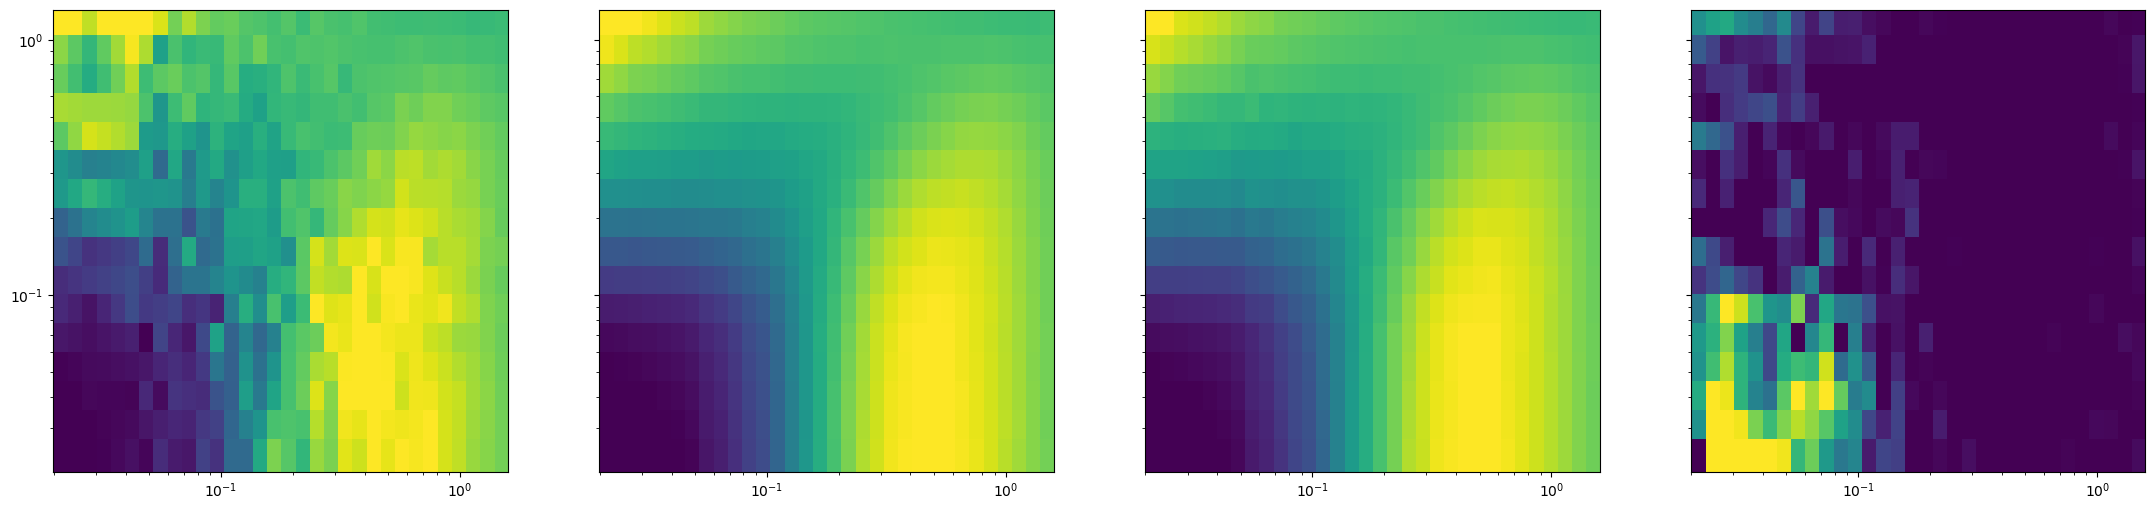

9 5.0252094 0.18591734319925307 5.127914071083069 0.97131854


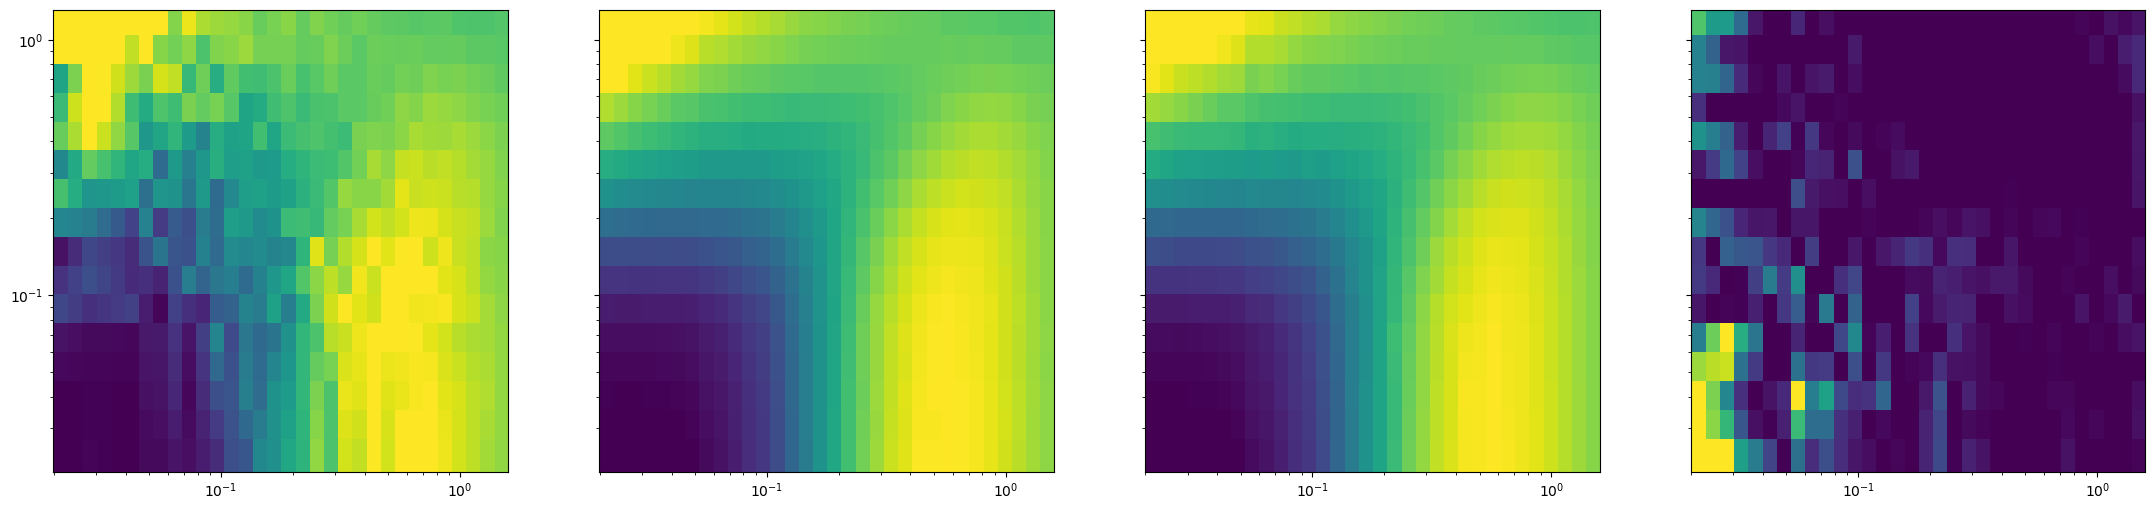

10 5.02802 0.1806906305253506 4.64311312437057 3.1444187


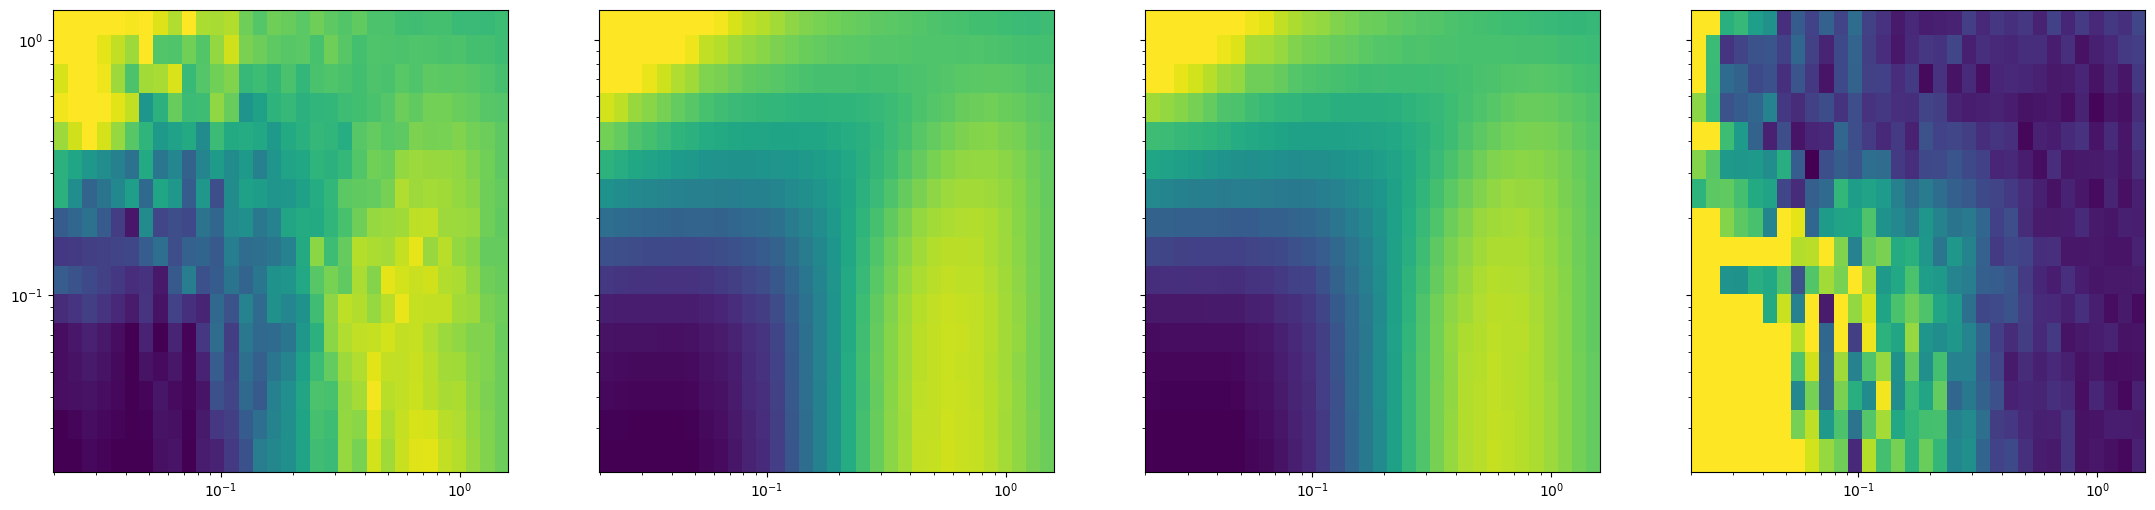

11 5.030833 0.49575620889663696 3.4310955107212044 4.9813676


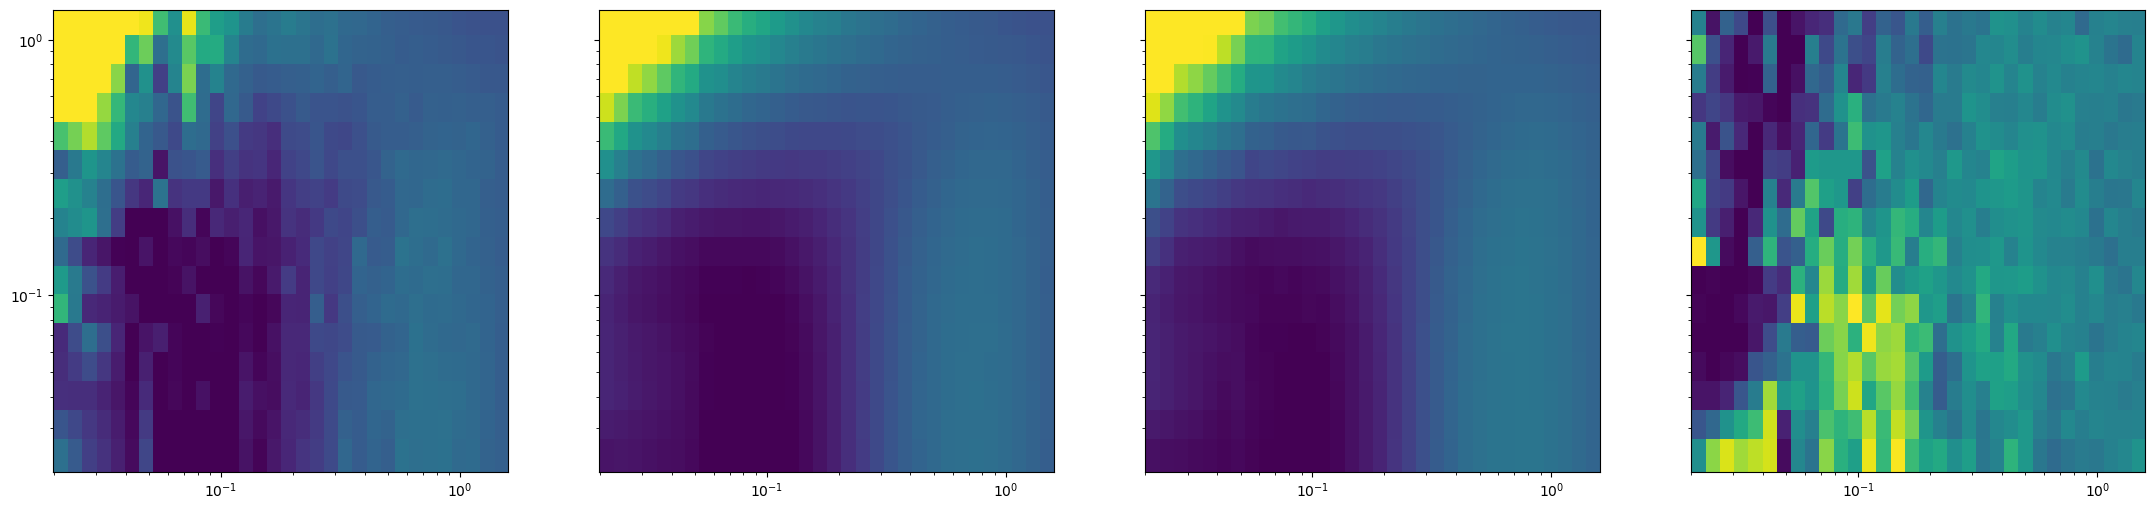

12 5.033647 1.2306012690067292 7.087334477901458 1.7016356


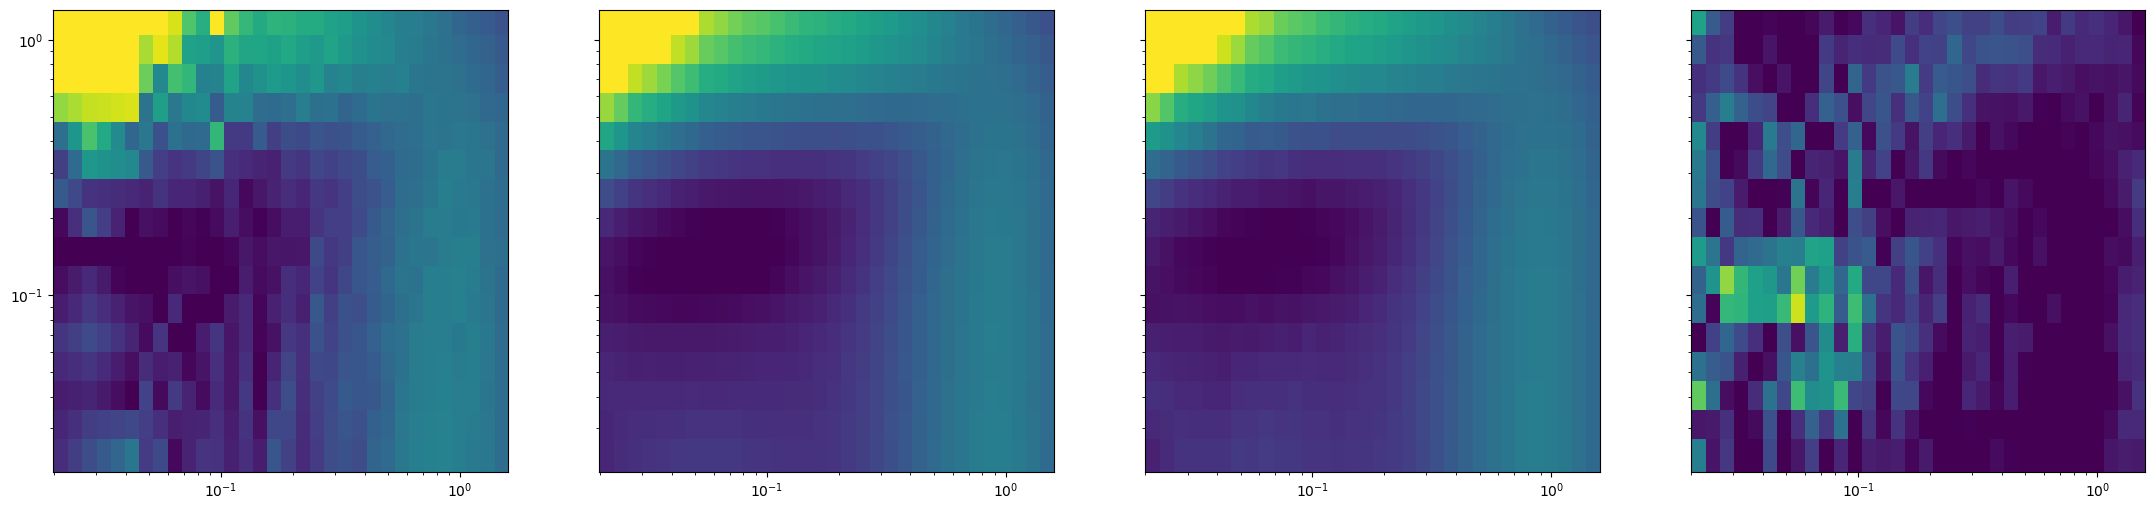

13 5.0364637 1.5888593196868896 9.679829645156849 2.5935626


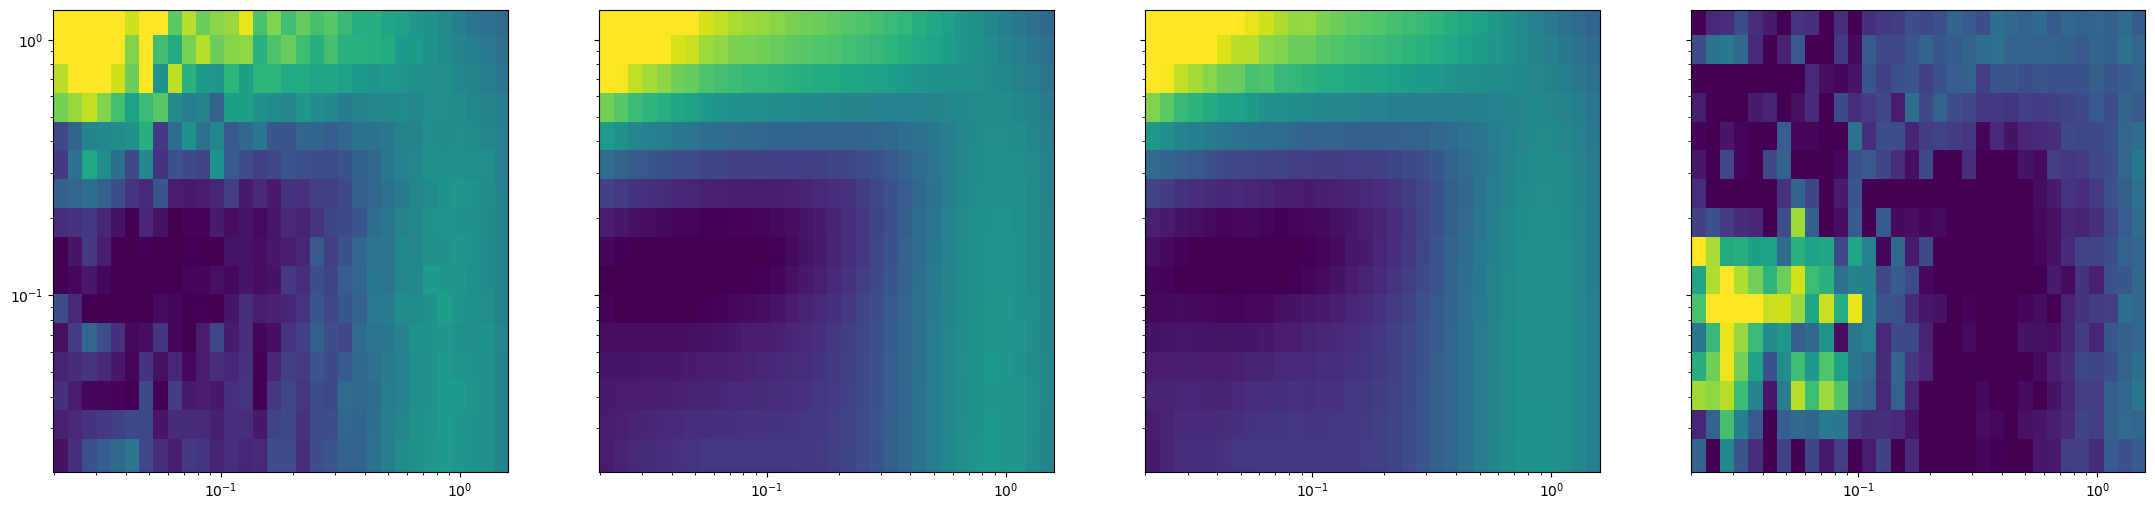

14 5.0392823 2.6299139261245728 27.475372600555417 0.6064594


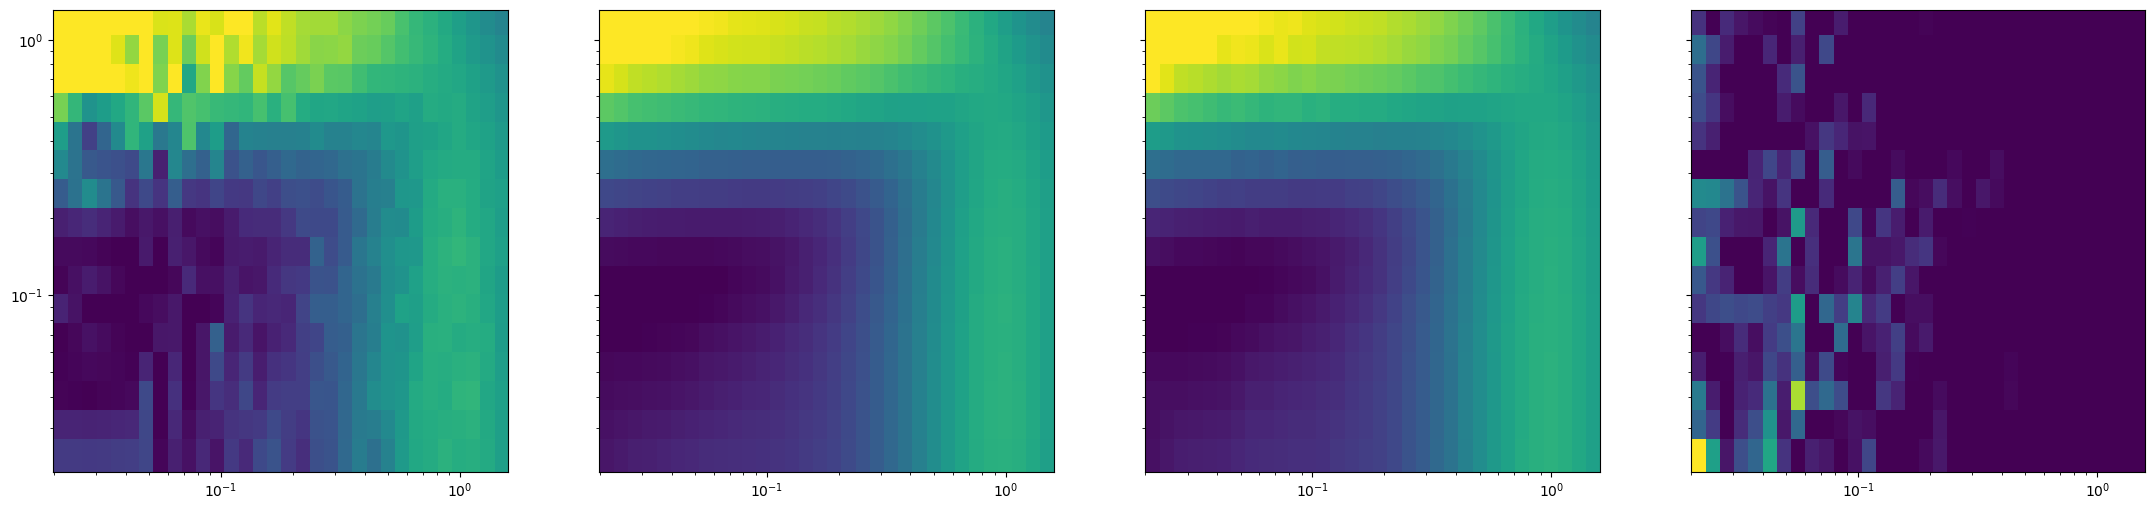

15 5.042103 3.562634617090225 87.10417118072509 0.8895947


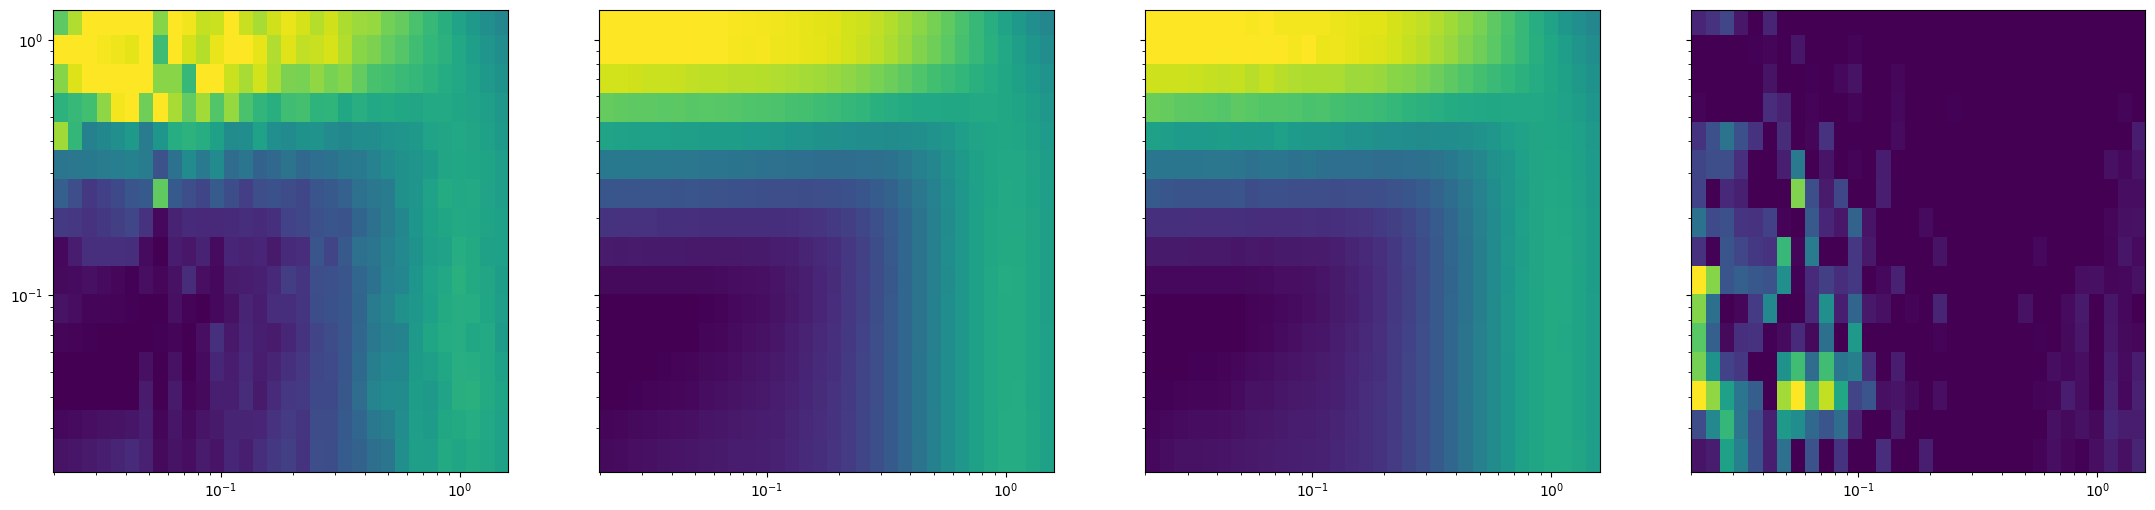

16 5.044925 3.7990906715393065 129.4951316833496 1.2766652


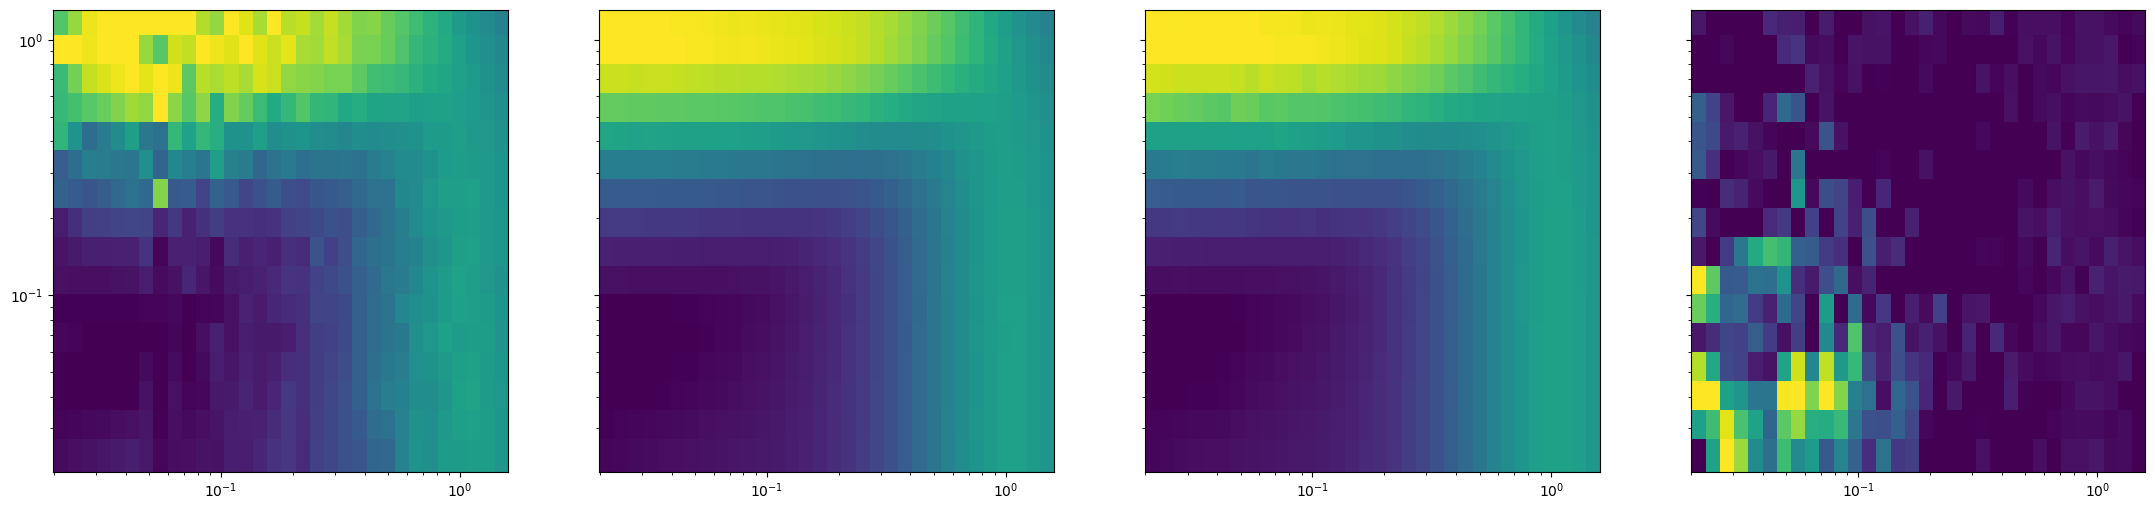

17 5.0477495 3.672407865524292 201.5889808654785 0.72698617


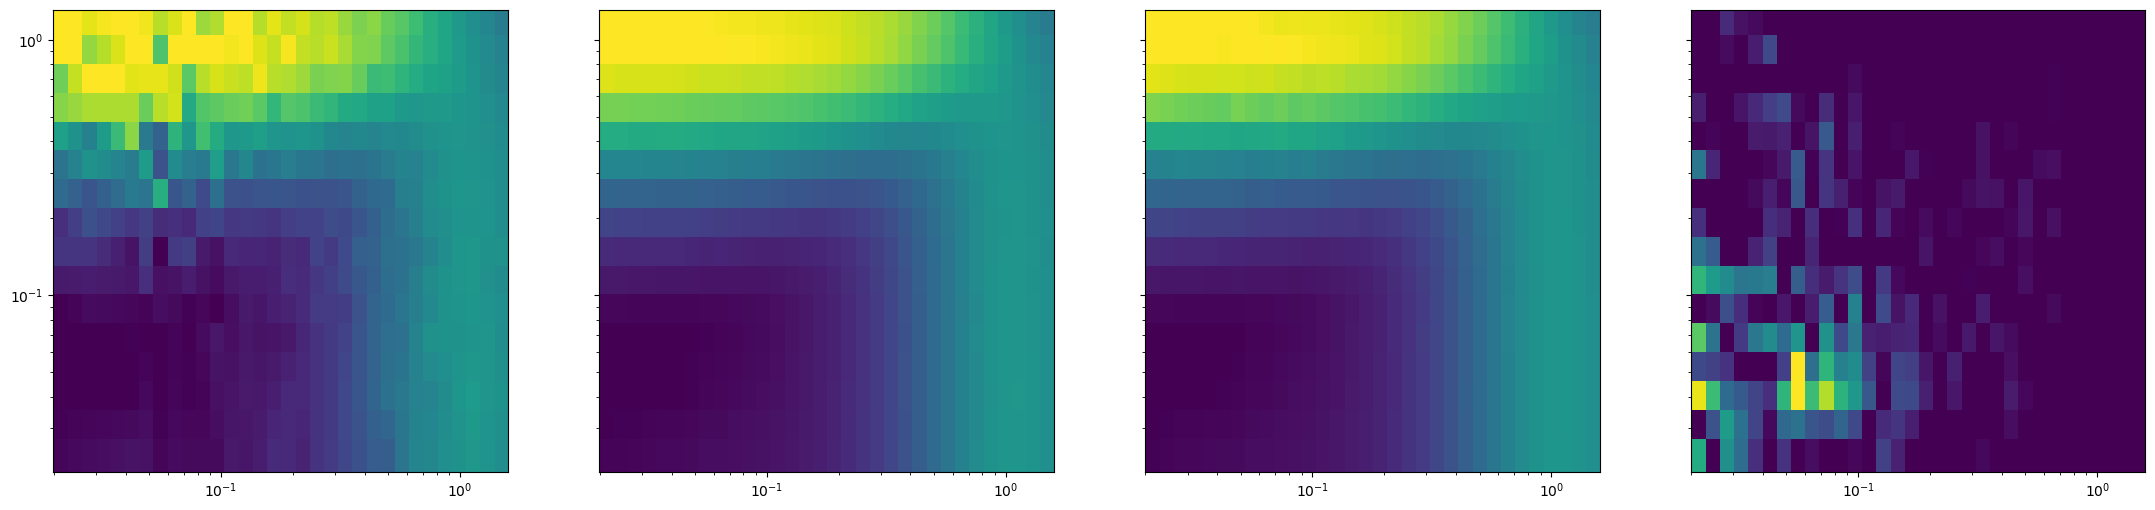

18 5.050576 3.8781753540039063 219.37549514770507 0.62698805


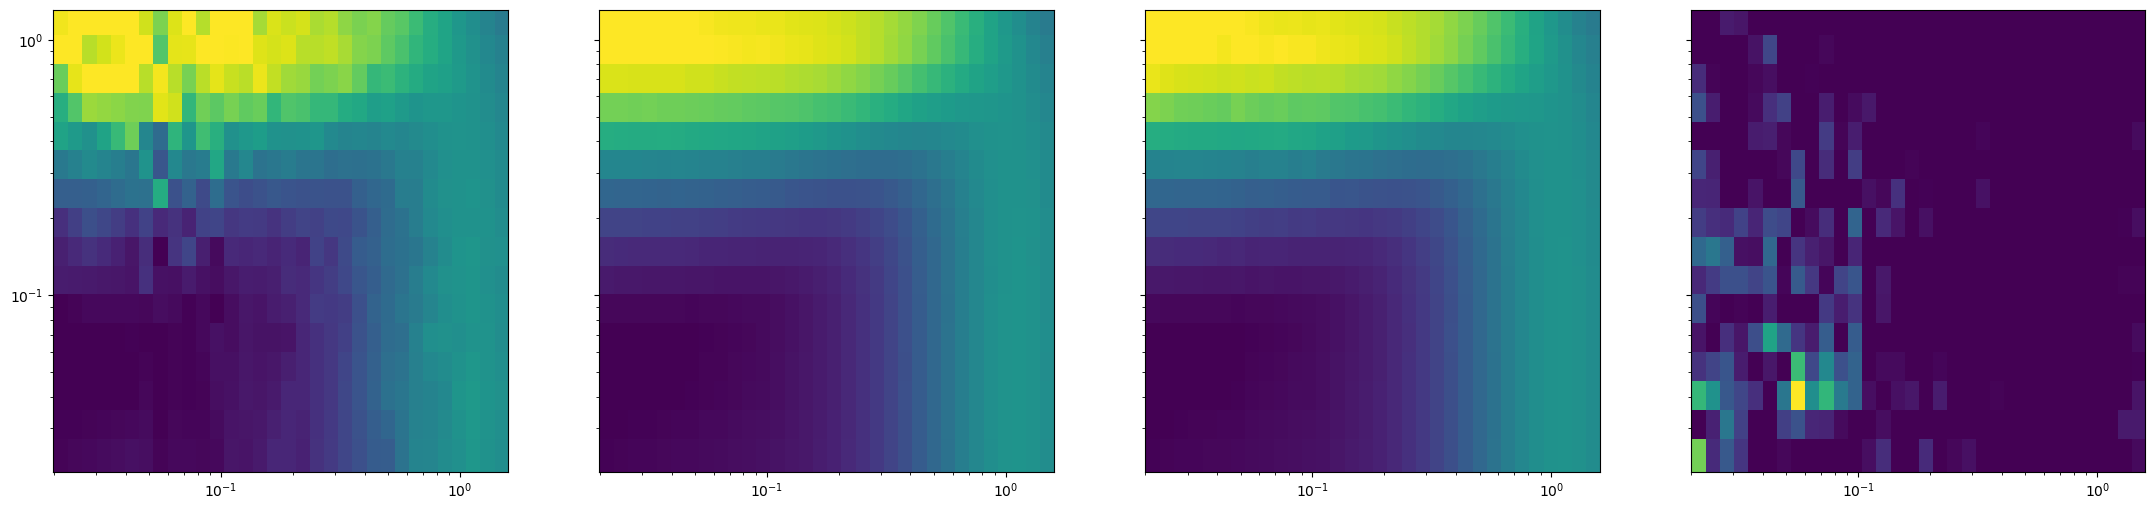

19 5.0534043 4.48608227968216 351.92745742797854 1.2890731


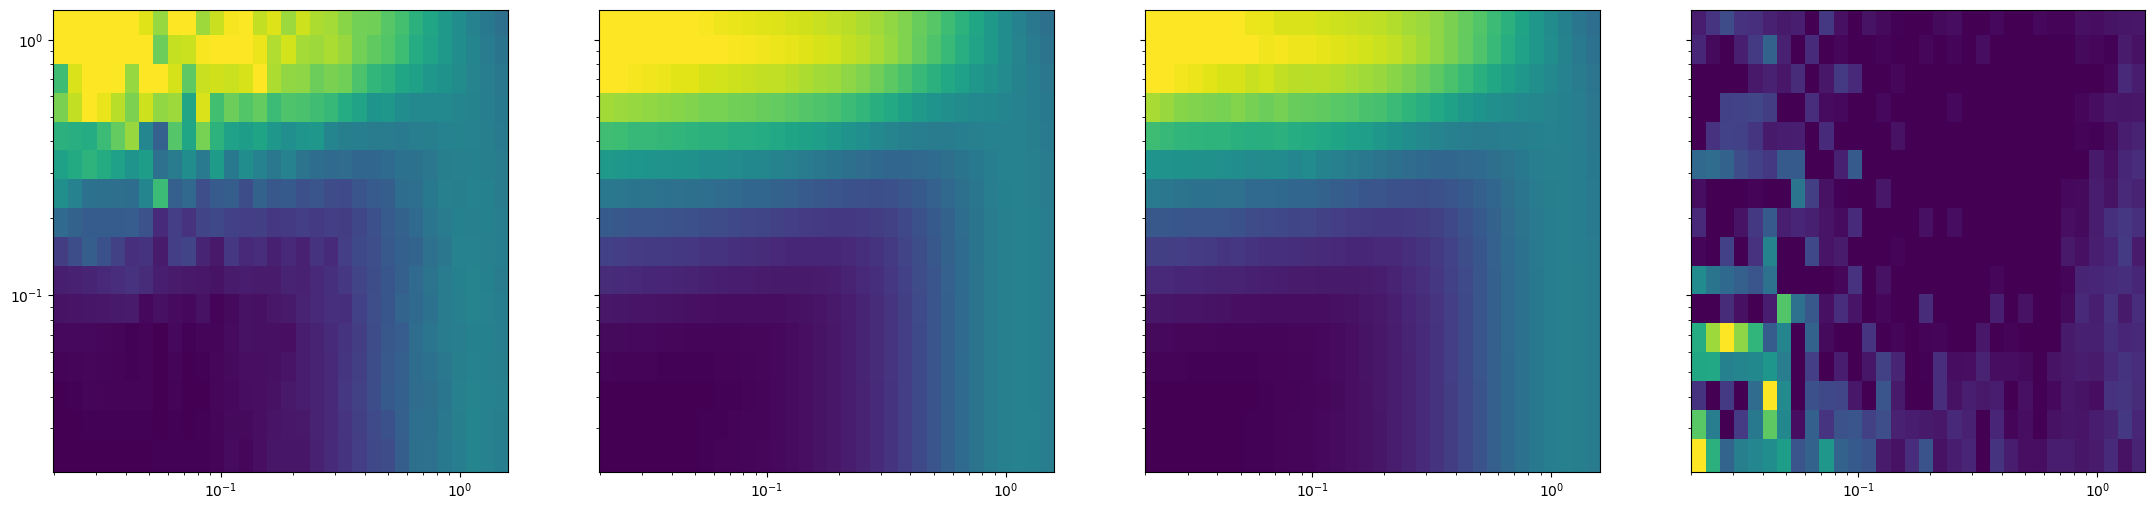

20 5.056235 7.901268815994262 461.7302177429199 1.3290265


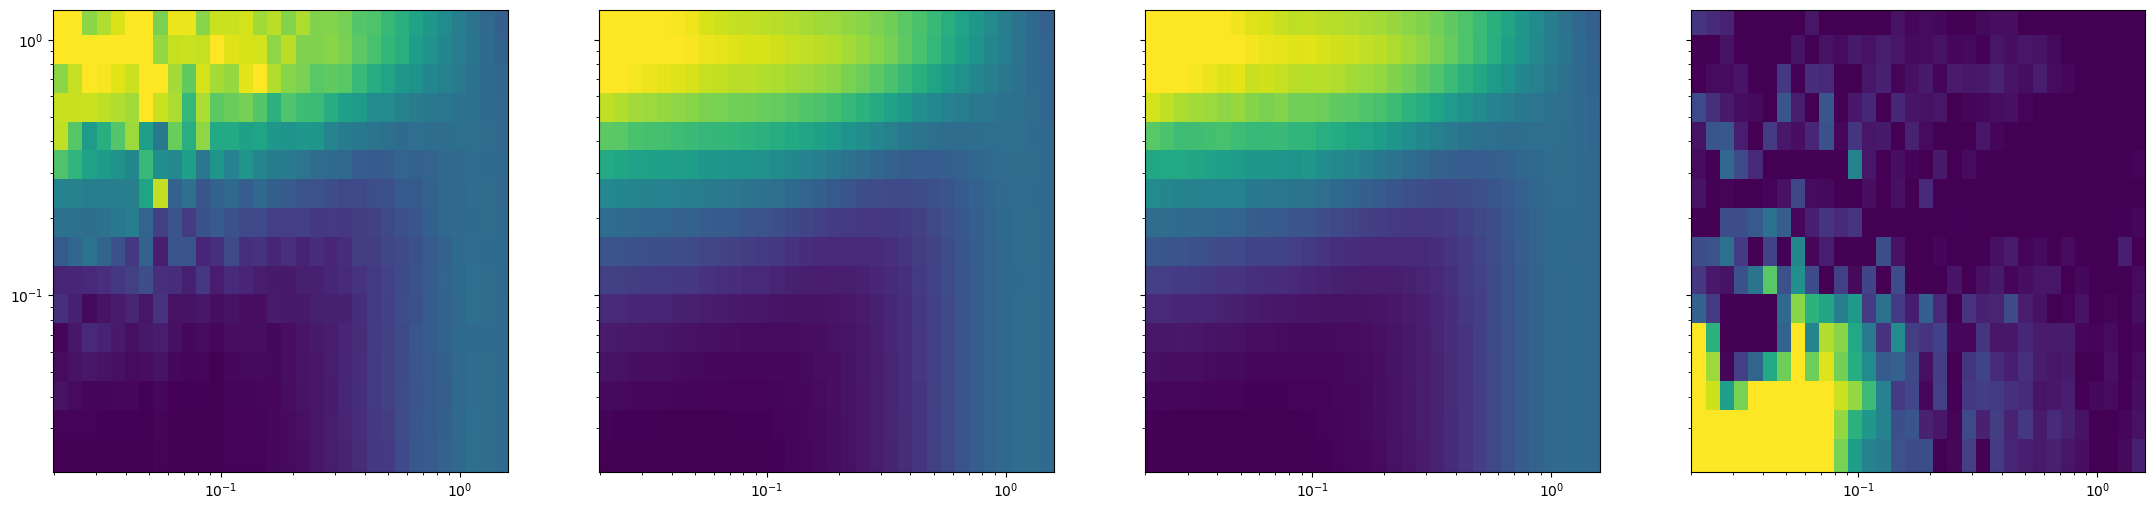

21 5.059067 20.025658512115477 447.61708374023436 0.58015573


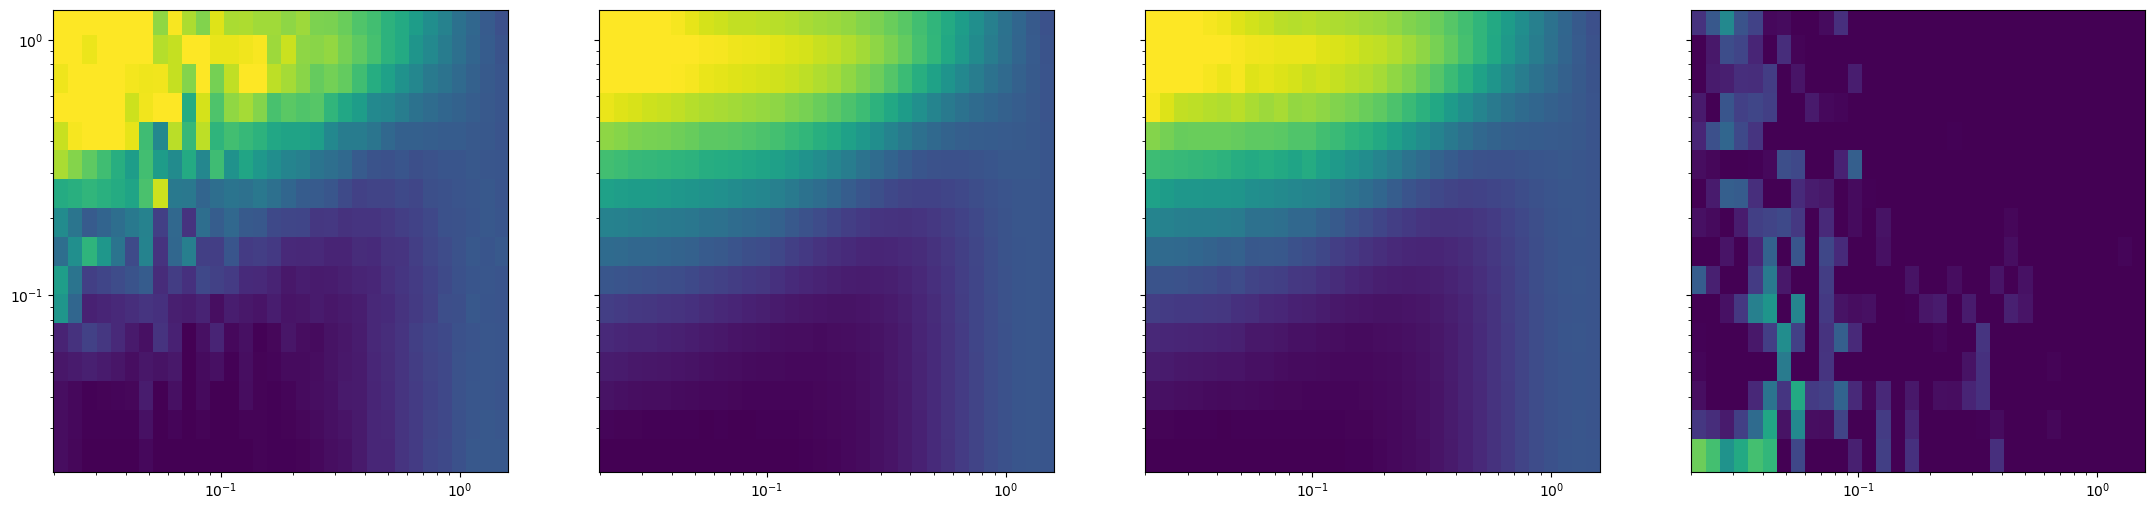

22 5.061901 34.117831802368165 339.02993621826164 0.4903636


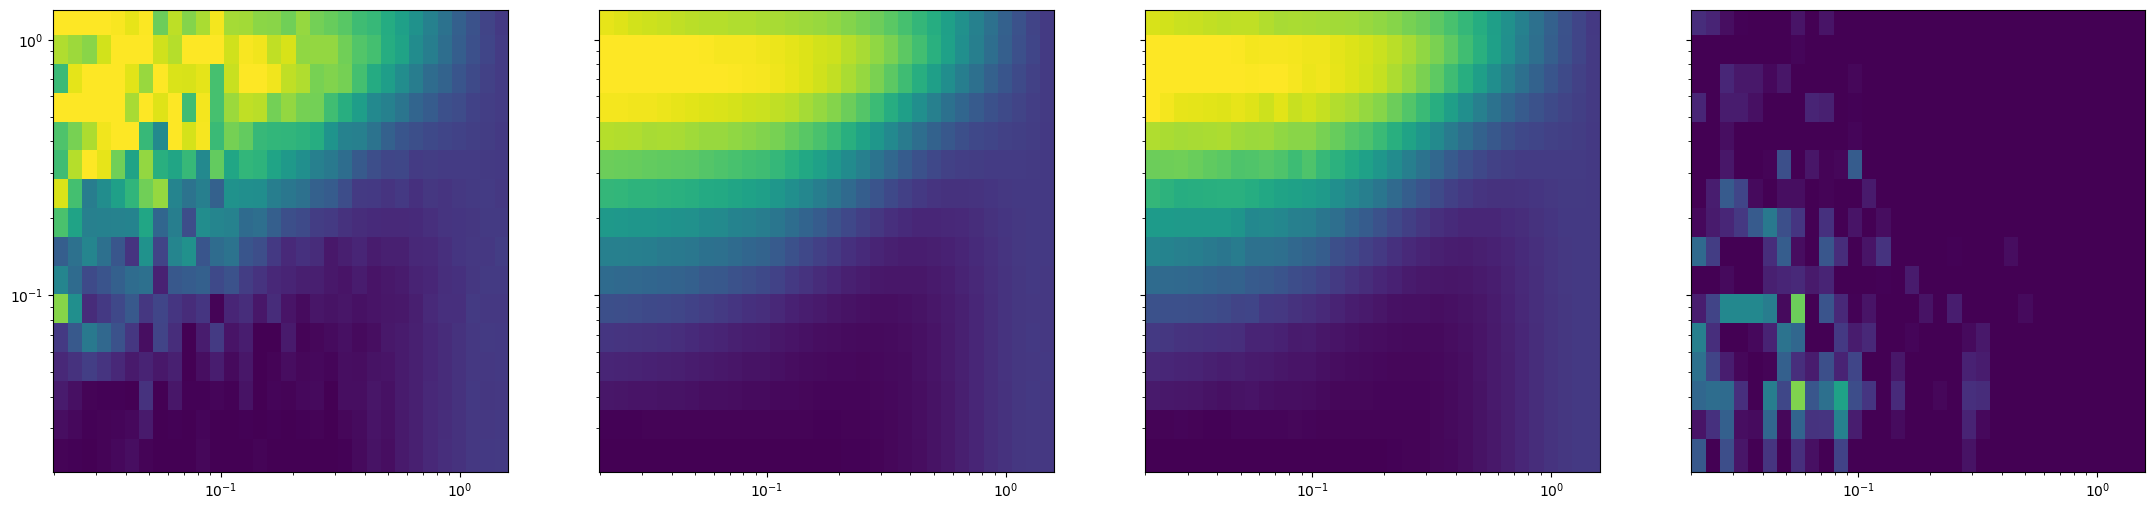

23 5.0647373 36.82691631317139 225.3987781524658 2.067833


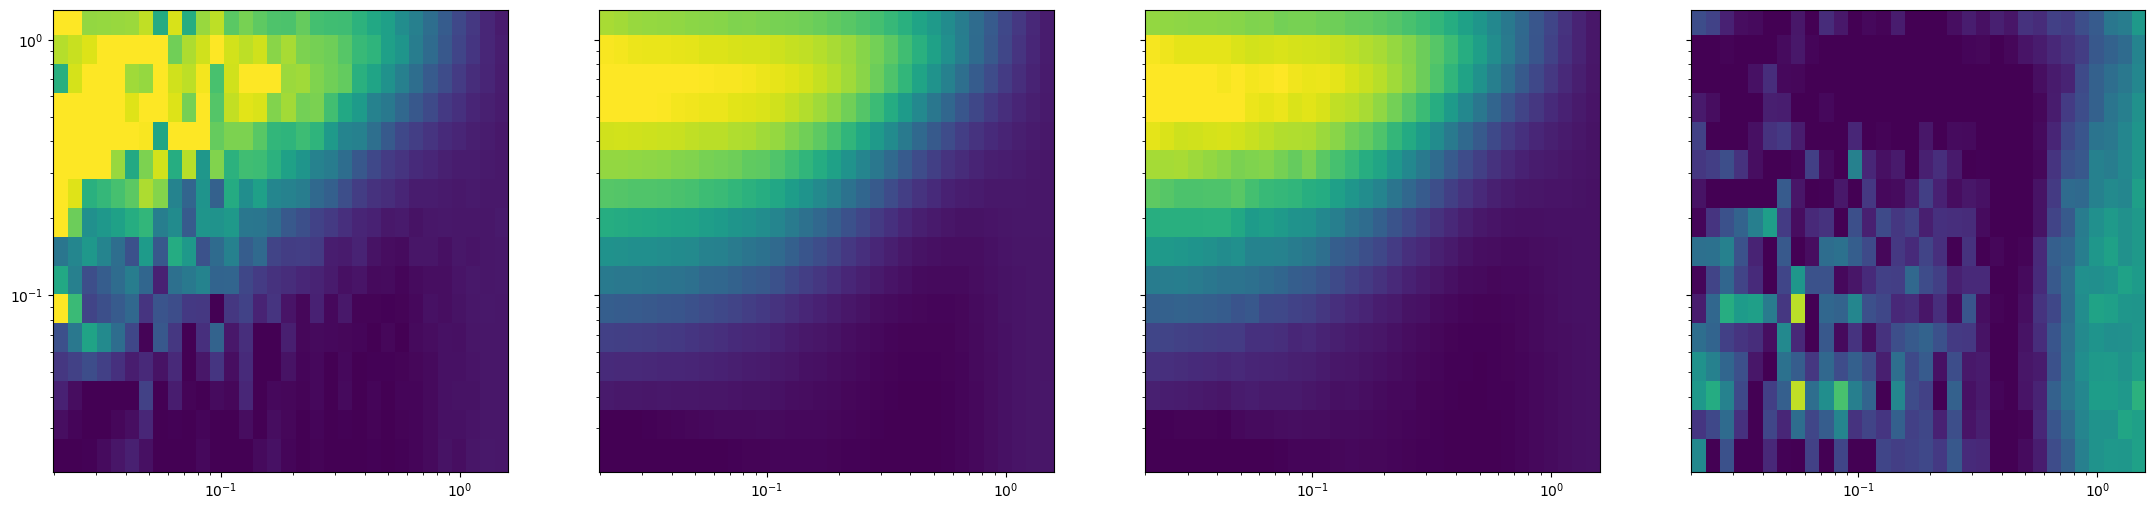

24 5.0675755 22.716246795654296 136.8036304473877 1.8351197


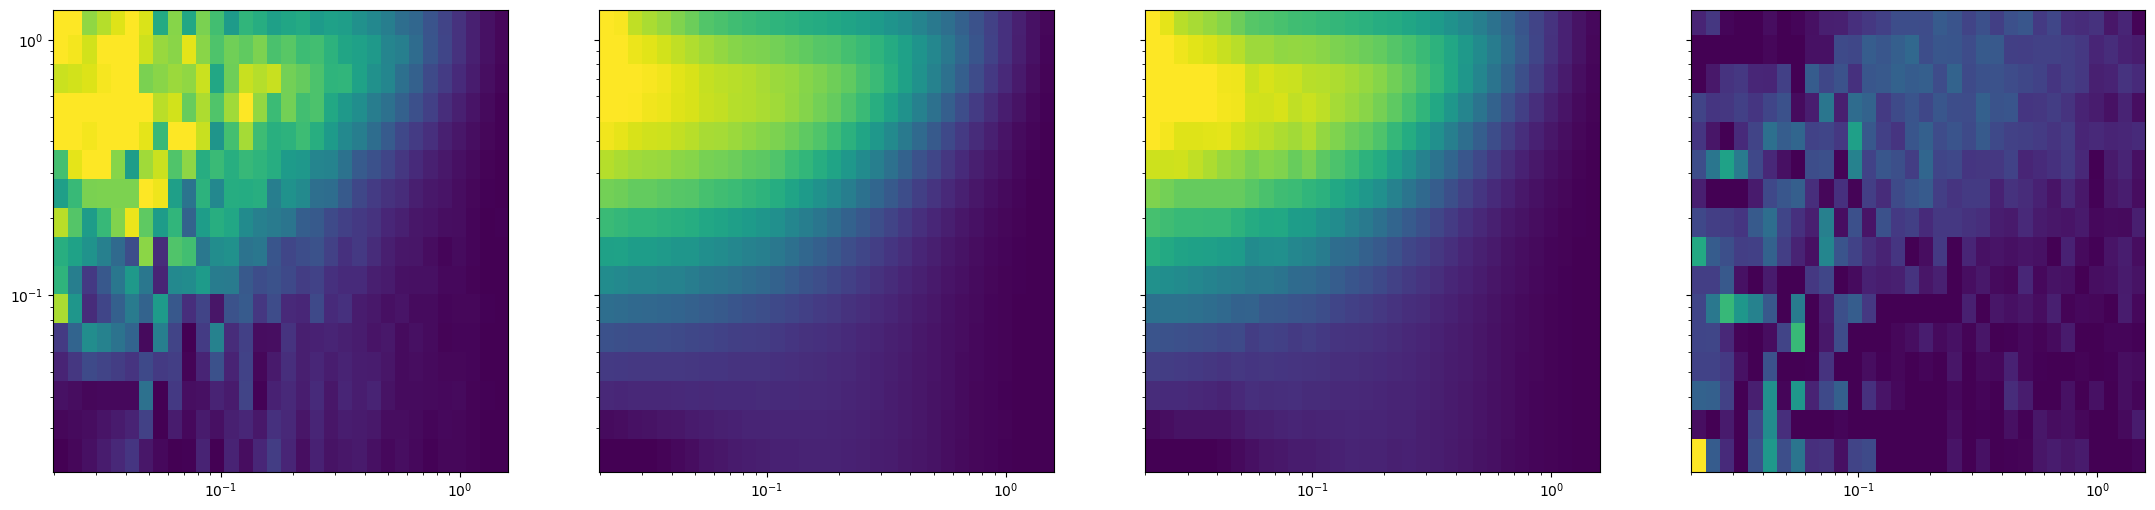

25 5.0704155 11.77718493938446 74.64131641387938 1.6201495


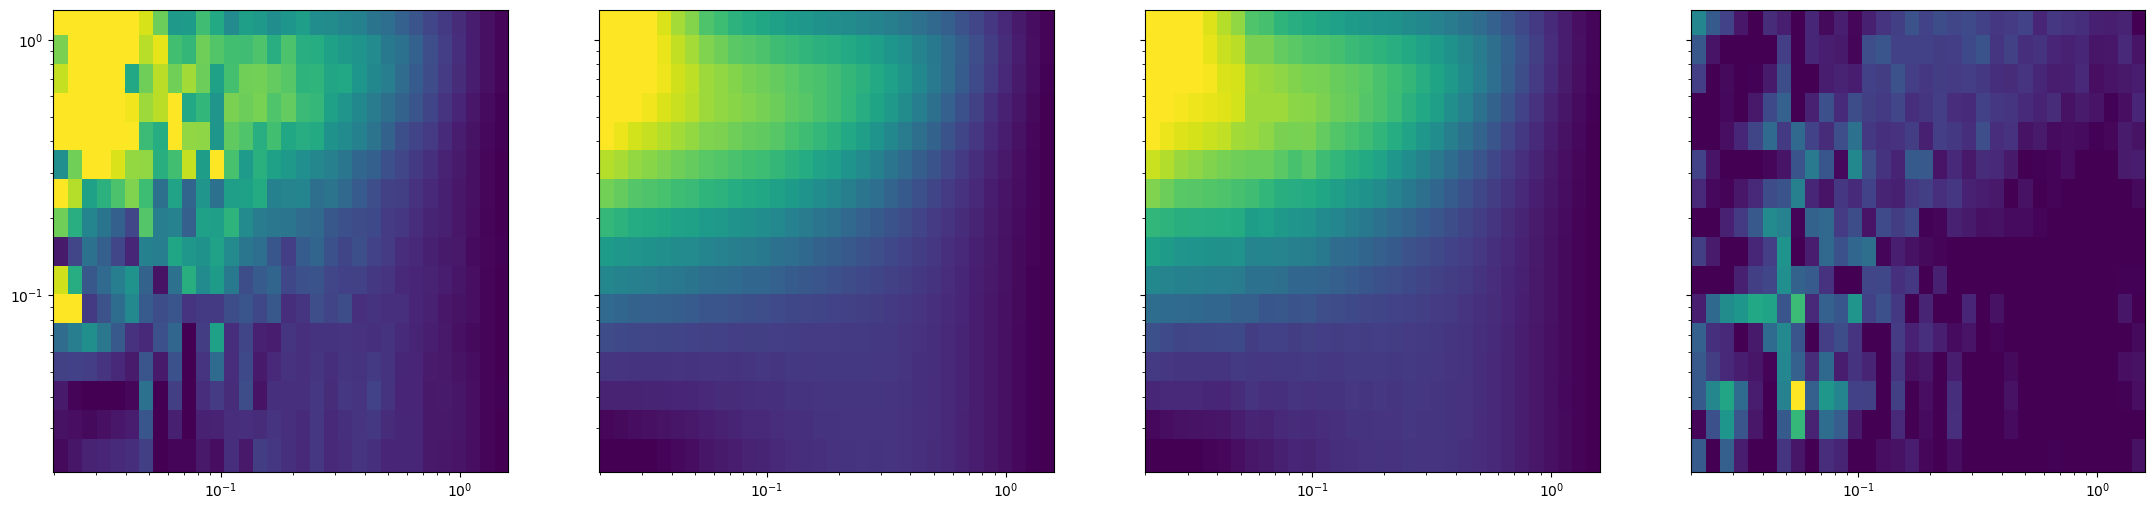

26 5.073258 8.74198875427246 53.62209711074827 1.173398


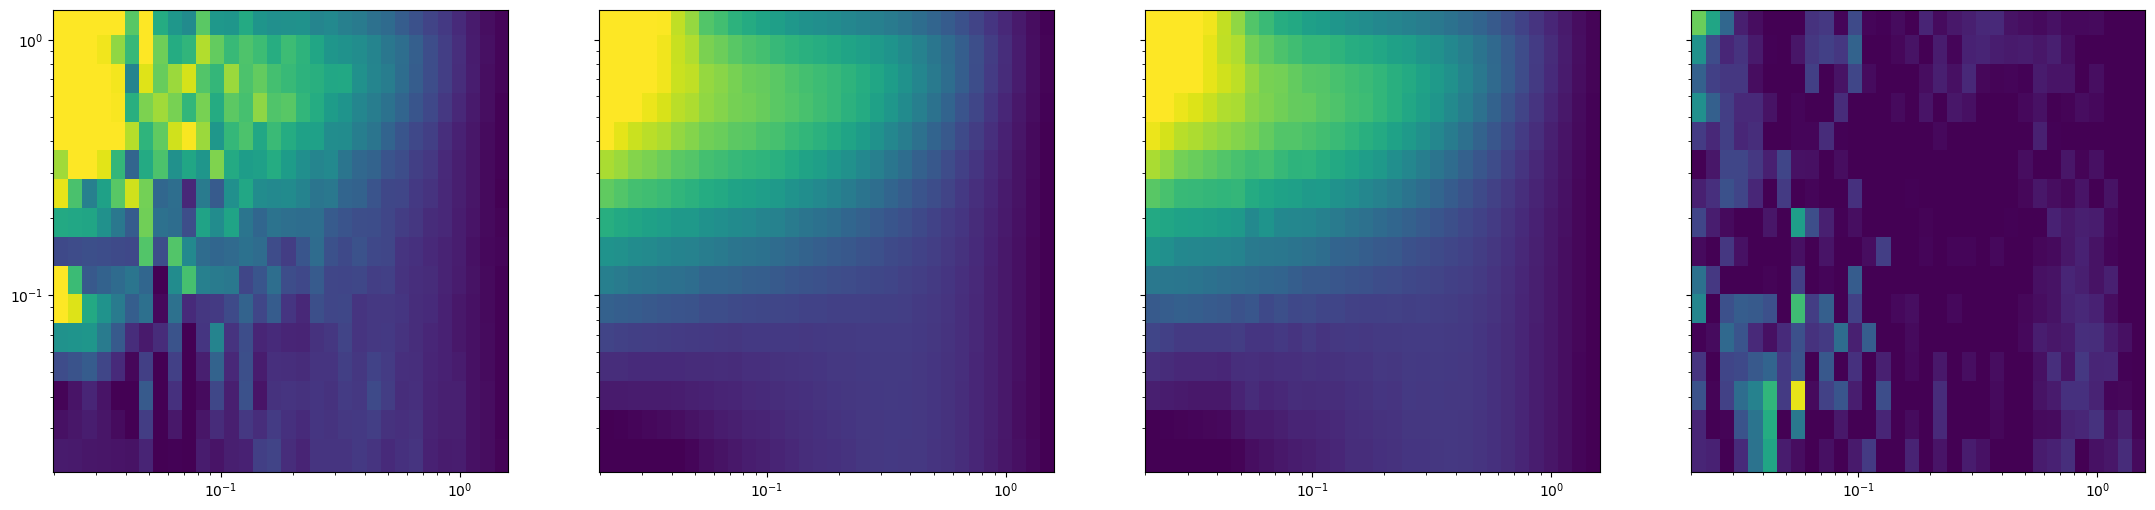

27 5.076102 6.352438390254974 36.35246858596799 0.7503566


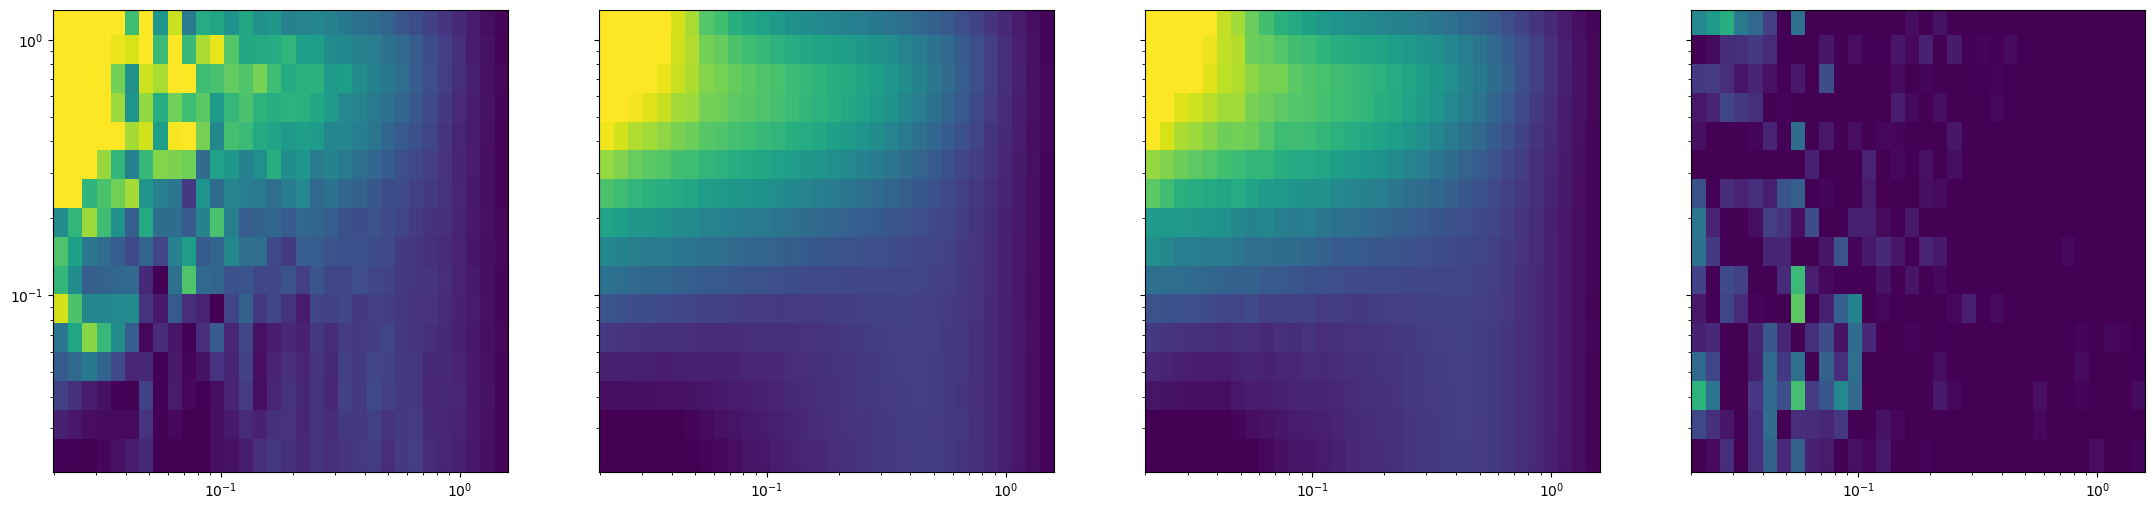

28 5.078948 2.148554575443268 15.592527198791492 1.8439286


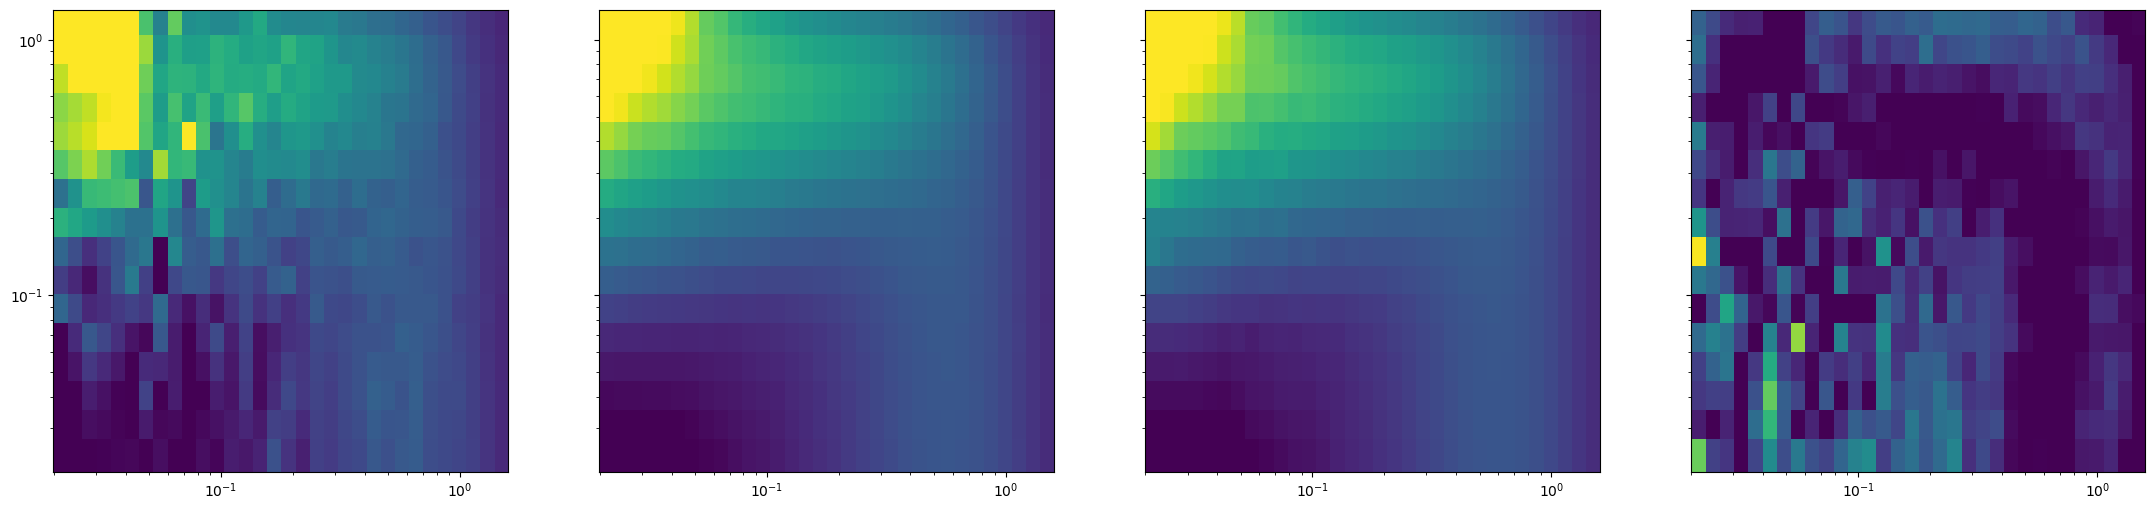

29 5.081796 0.5830989331007004 5.640049779415128 1.3067772


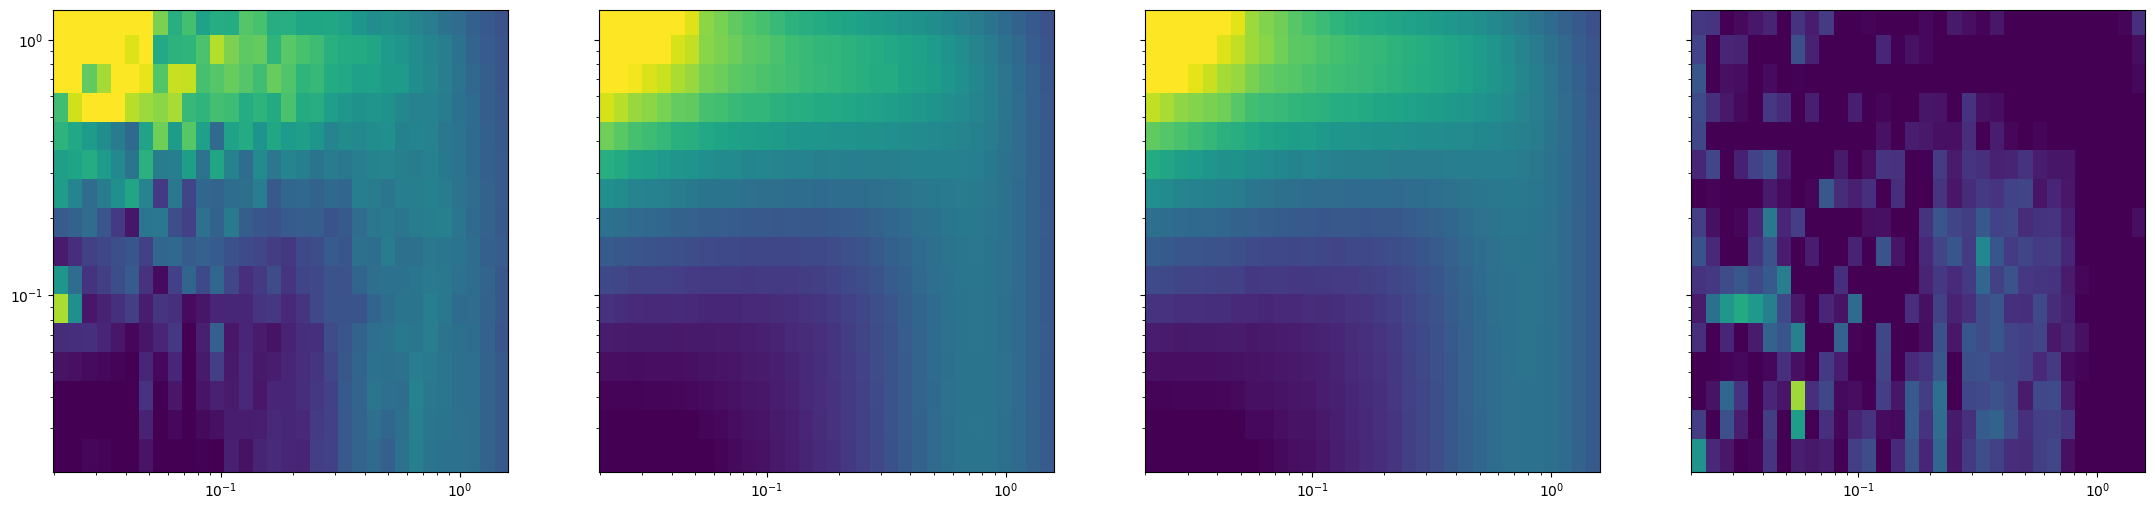

30 5.084646 0.13567280545830726 1.7861105054616908 0.99710786


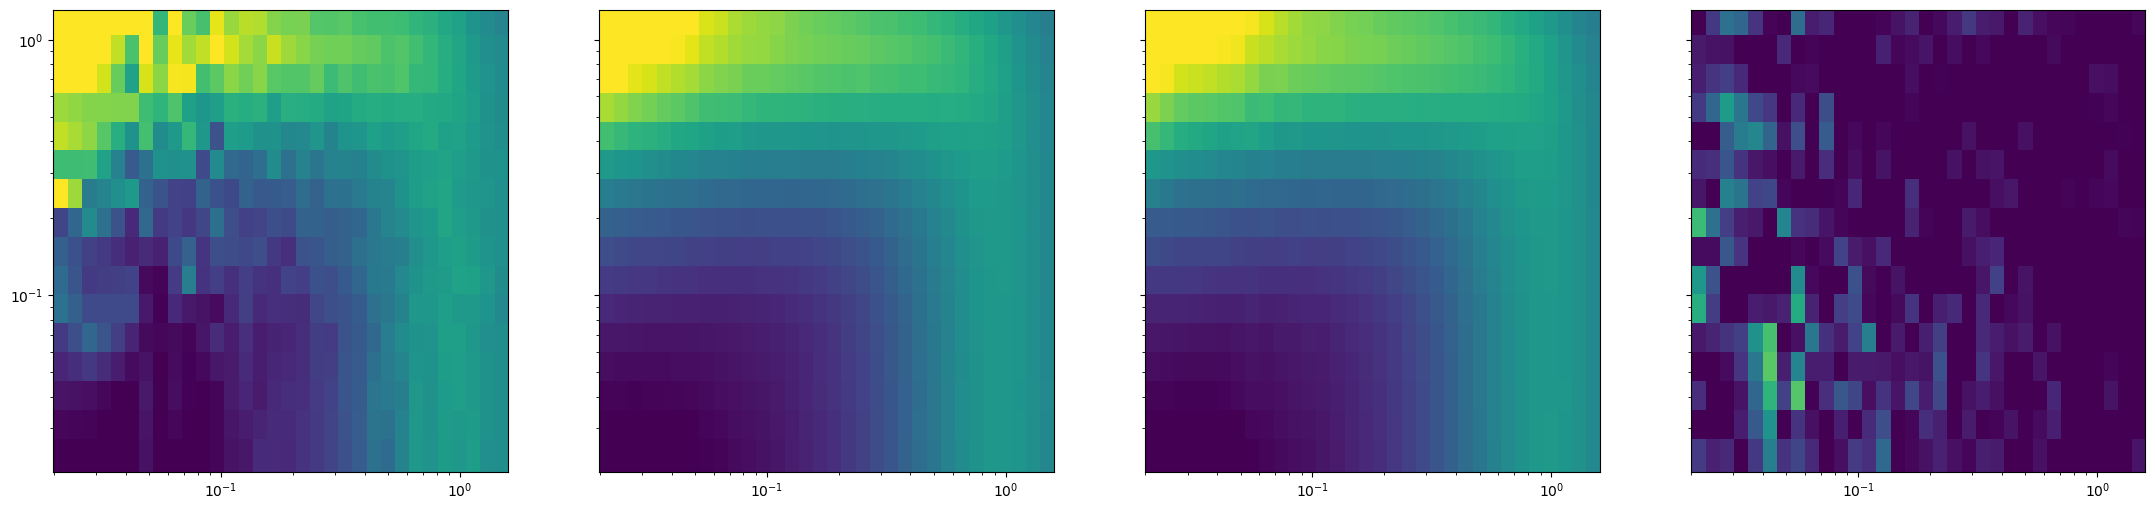

31 5.087498 0.03314313404262066 0.5817429125308987 2.0735912


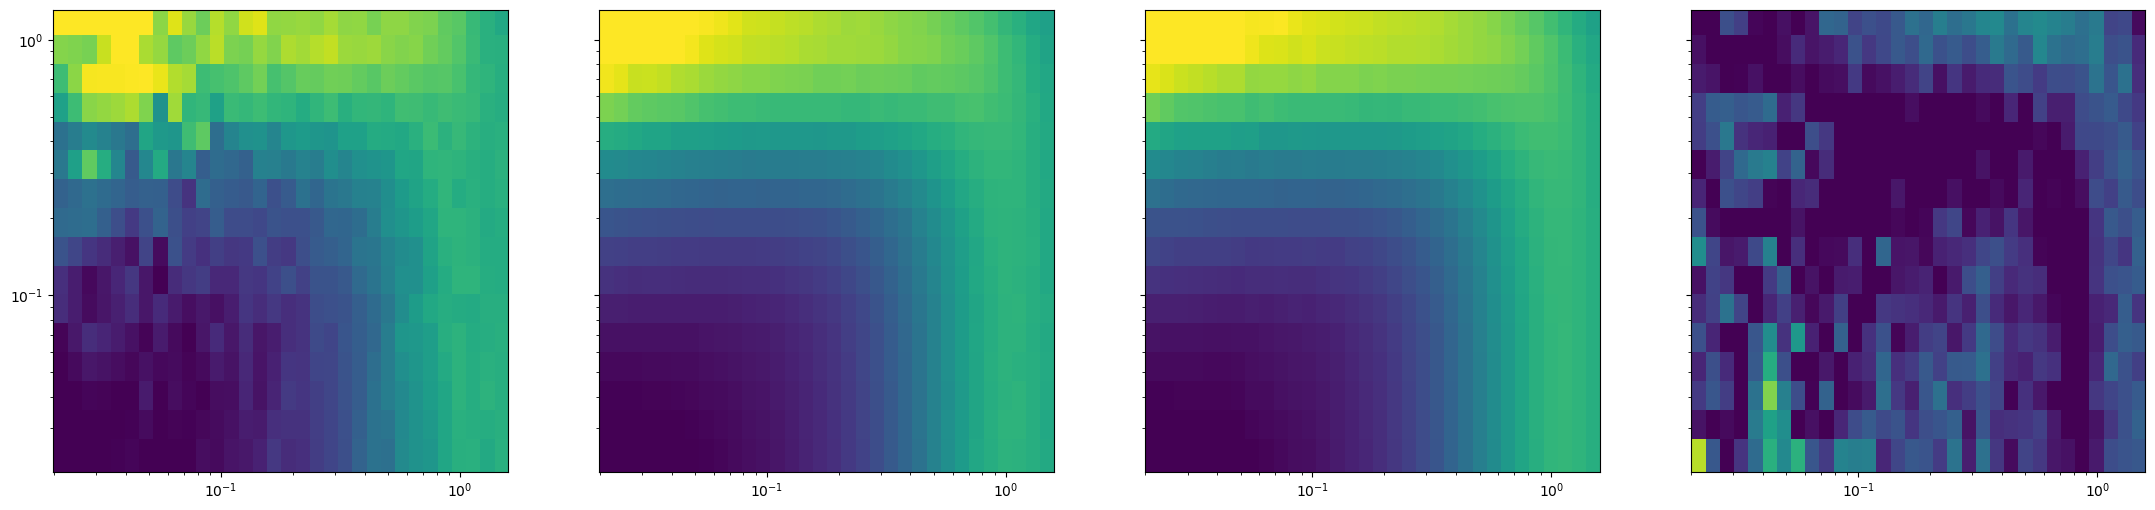

32 5.090352 0.01720674012321979 0.30937710255384443 1.1863829


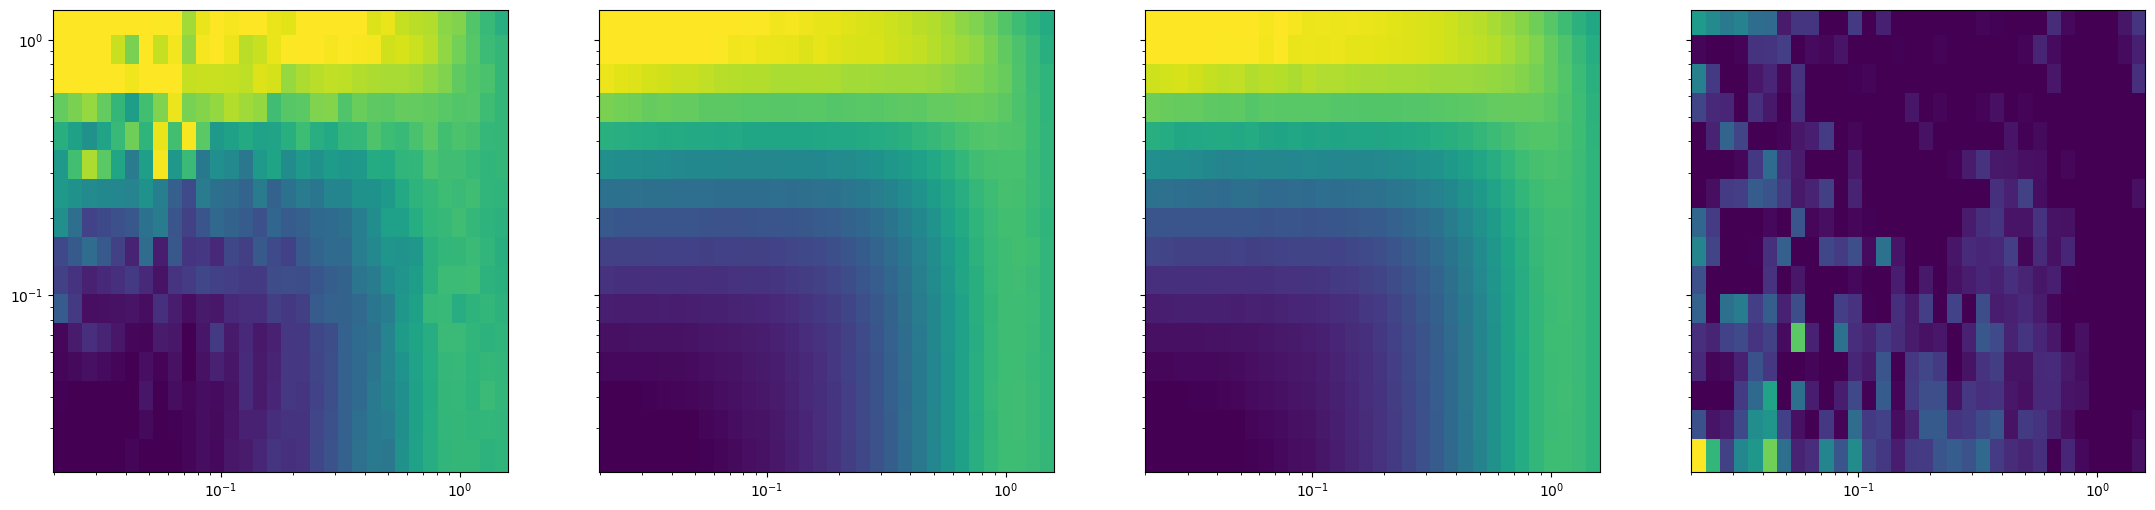

33 5.0932083 0.013484864193014801 0.24437728263437747 2.6630673


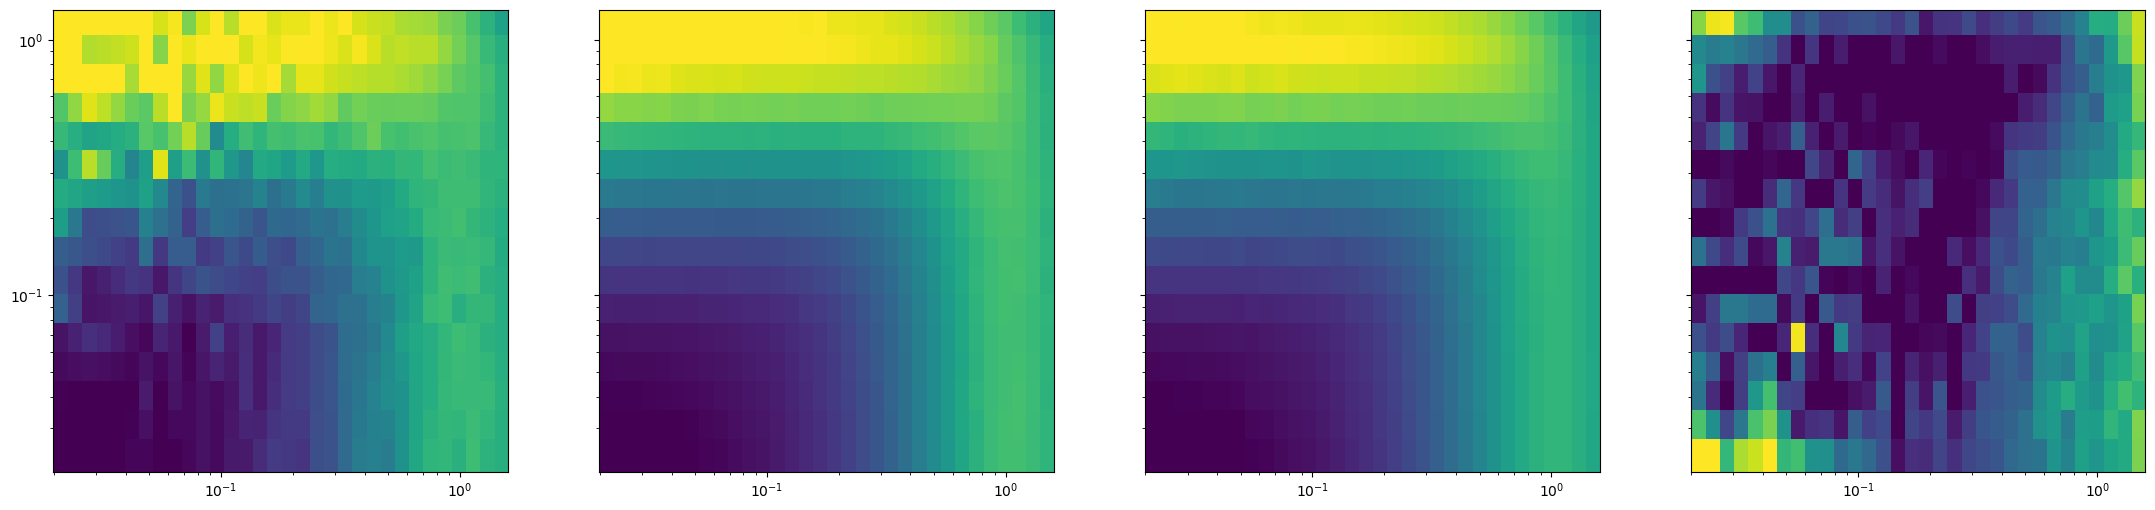

34 5.096066 0.012507486157119274 0.21663328558206557 2.617059


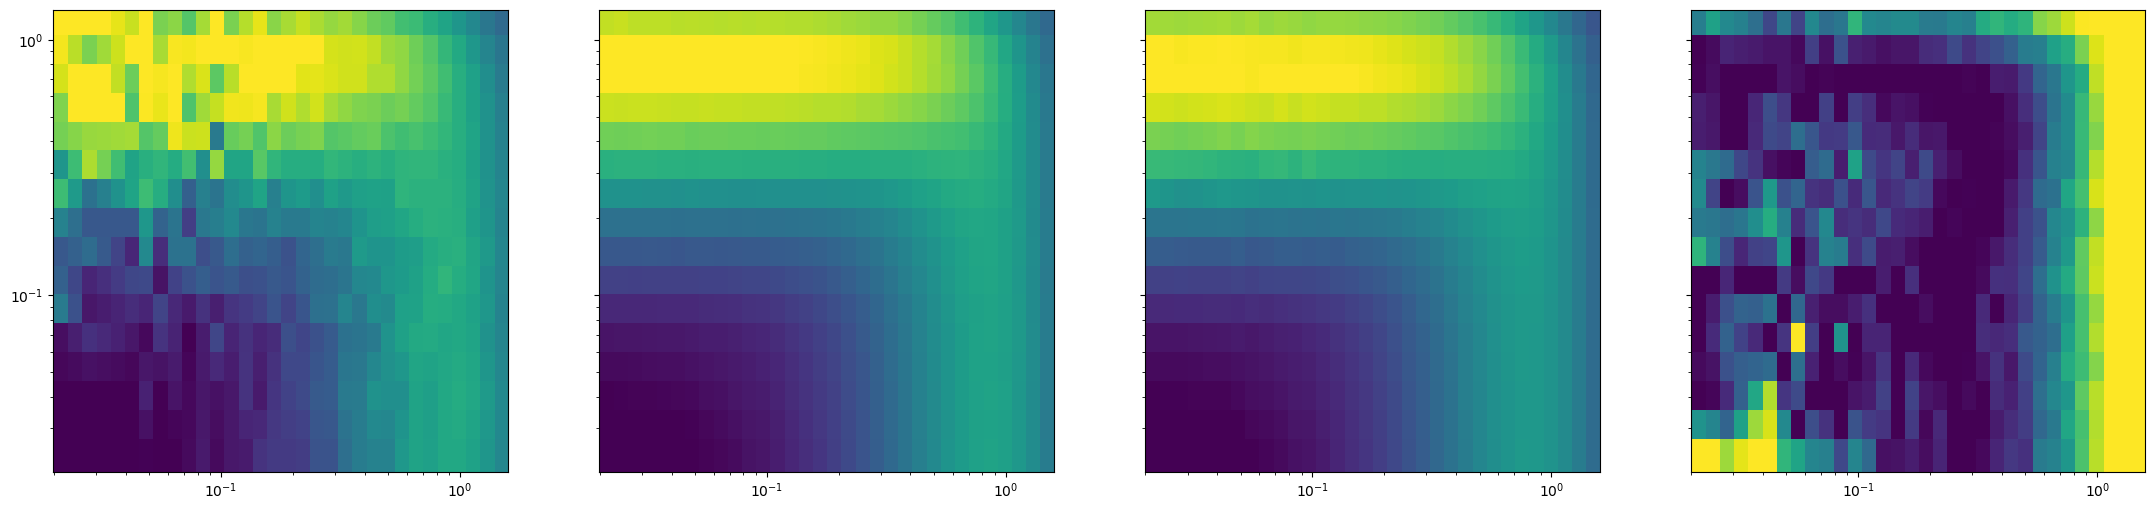

35 5.098926 0.018230588221922518 0.3164744988083839 0.8223133


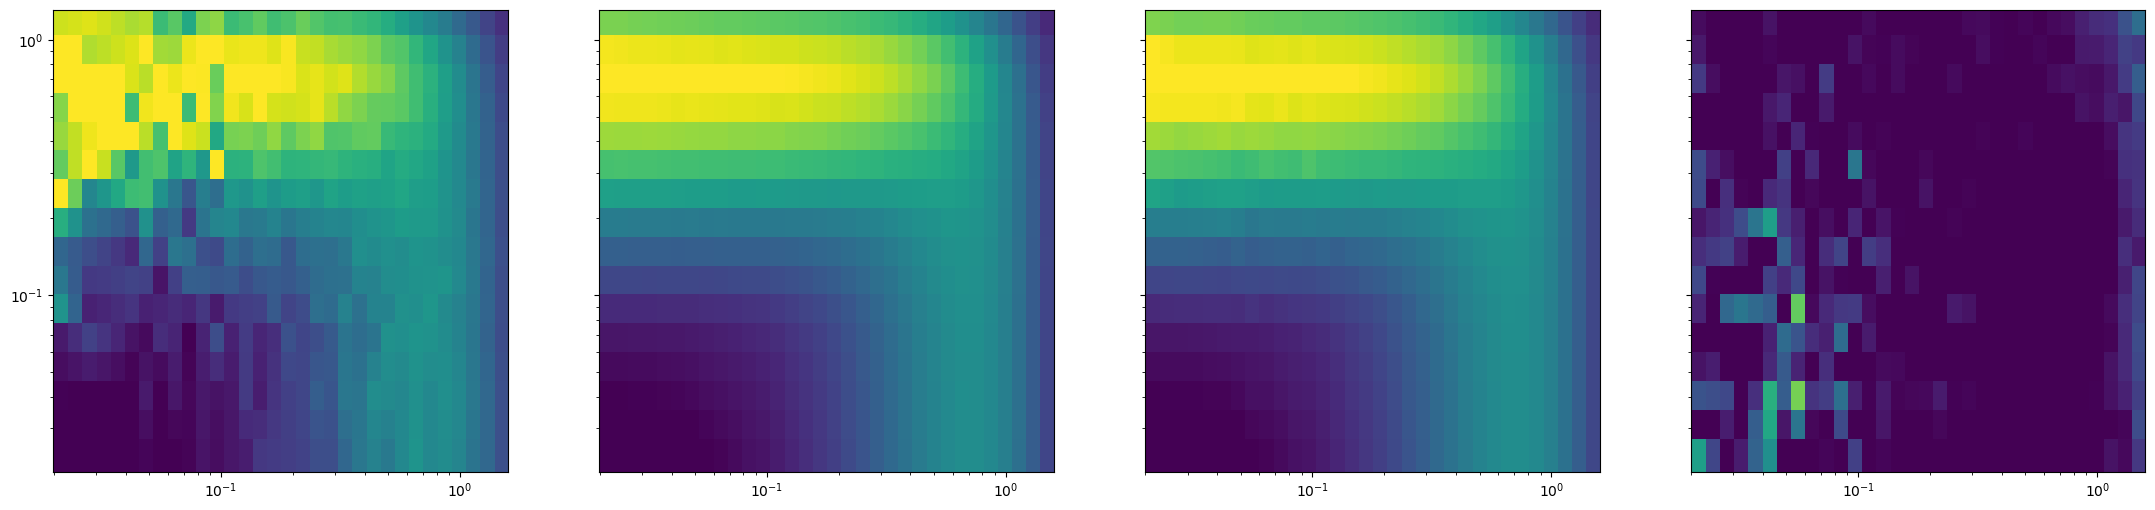

36 5.101788 0.026843214640393853 0.48626008182764047 0.9499472


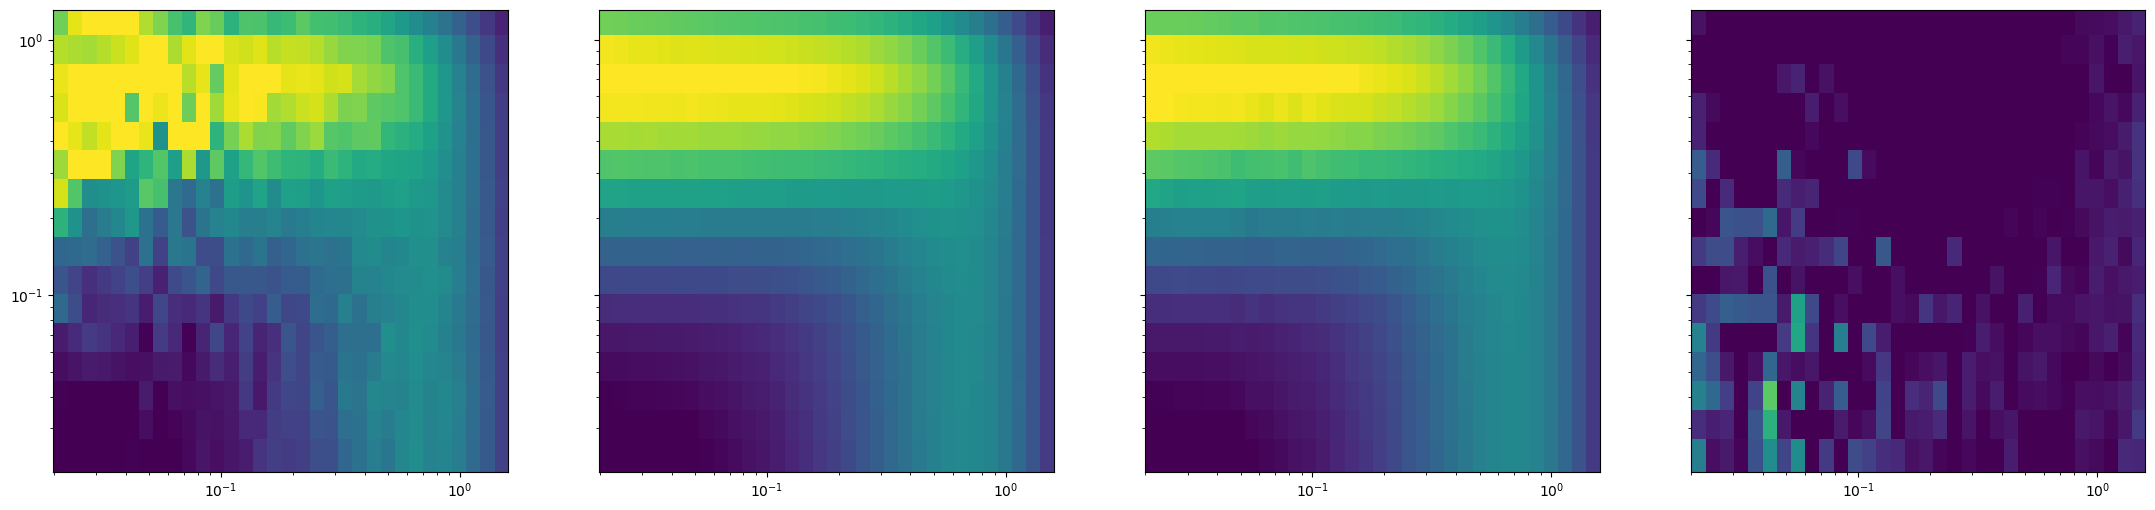

37 5.1046524 0.04139987286180258 0.753634649515152 0.6554568


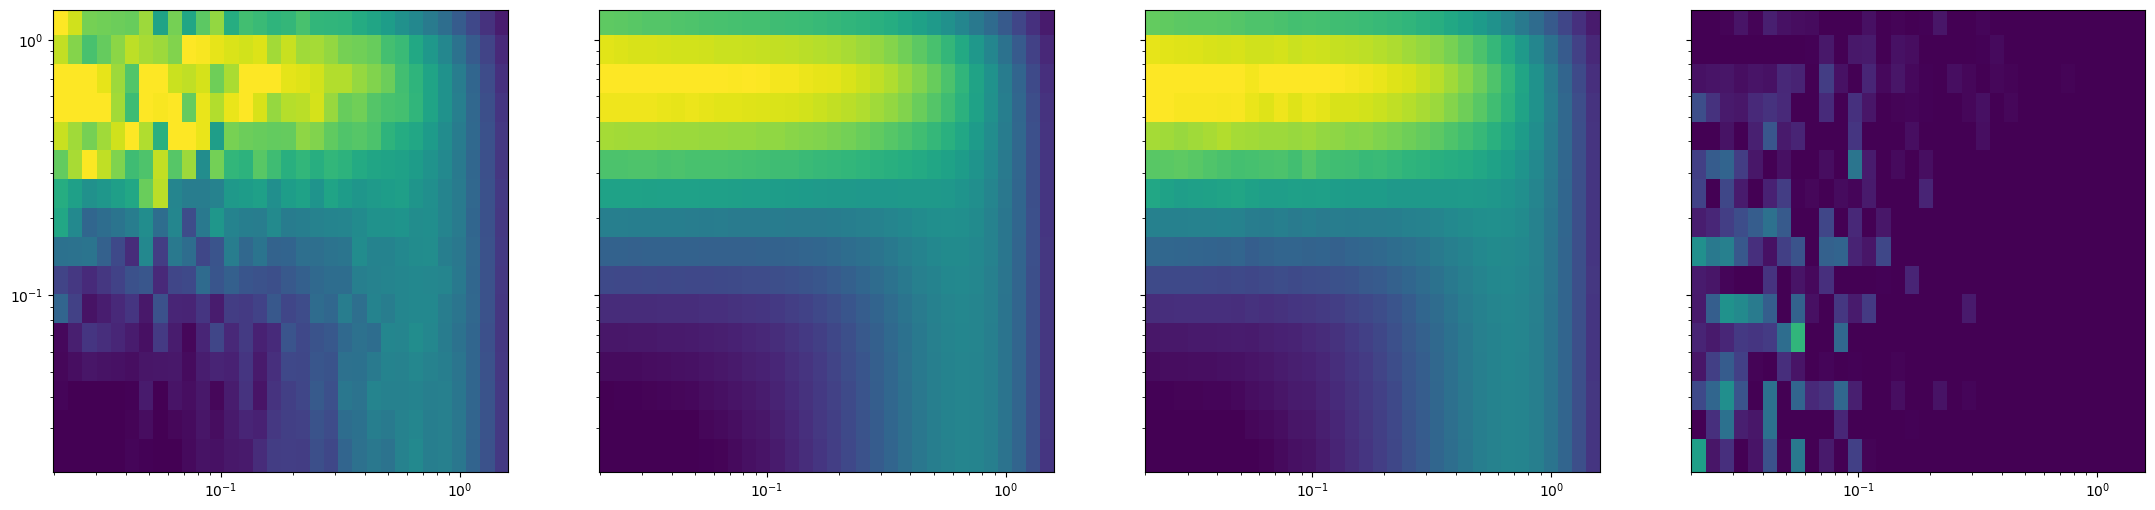

38 5.107518 0.06128331106156111 1.0875634282827378 0.6635833


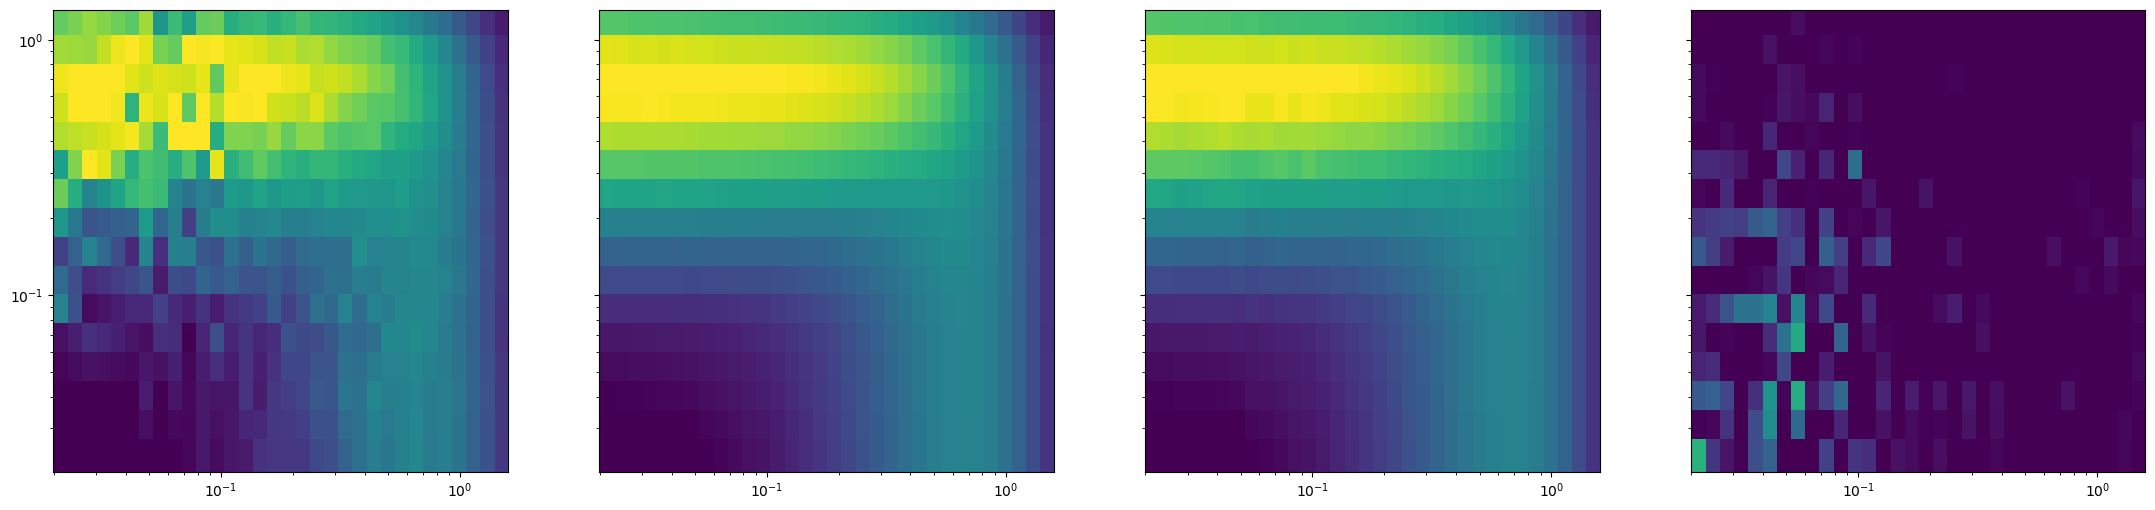

39 5.1103864 0.06367893498390913 1.1313396692276 0.72757065


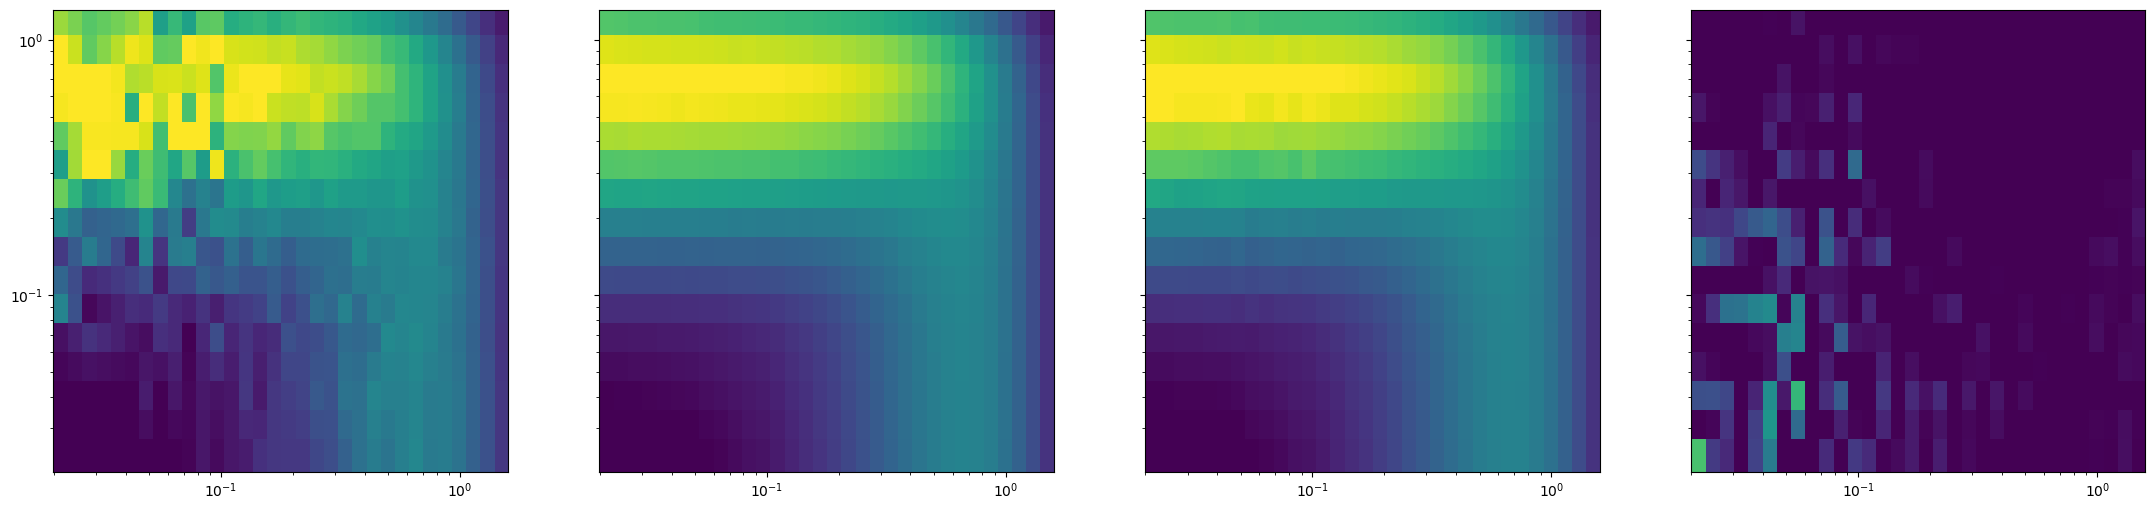

In [26]:
for i in range(seeds.shape[1]):    
    fig, axs = plt.subplots(nrows = 1, ncols = 4, sharey=True, figsize = (27,6))
    vmin = np.percentile(mean[5,i], 2.5)
    vmax = np.percentile(mean[5,i], 97.5)
    axs[0].pcolormesh(kperp, kpar, seeds[5,i].T, vmin=vmin, vmax=vmax)
    axs[1].pcolormesh(kperp, kpar, mean_estimate[i].T, vmin=vmin, vmax=vmax)
    axs[2].pcolormesh(kperp, kpar, mean[5, i].T, vmin=vmin, vmax=vmax)
    err = np.abs((mean[5,i] - mean_estimate[i])/mean[5,i])*100.
    print(i, redshifts[i],vmin, vmax, np.median(err))
    axs[3].pcolormesh(kperp, kpar, err.T, vmin=1, vmax=10)
    axs[0].loglog()
    axs[1].loglog()
    axs[2].loglog()
    axs[3].loglog()
    plt.show()

In [10]:
mean_estimate.shape

(2, 32, 16)

In [16]:
from py21cmemu import EmulatorProperties

In [38]:
EmulatorProperties().ks_cut

array([0.03820577, 0.05725007, 0.07778031, 0.101638  , 0.1347107 ,
       0.1815186 , 0.2444601 , 0.3299734 , 0.4460977 , 0.6021986 ,
       0.8131821 , 1.097917  ])

In [98]:
k = np.load('/home/dbreitman/CV_PS_denoising/21CMMC/src/sensitivity_H6C_H7C.npz', allow_pickle=True)['sensitivity'].item()[300][220.0]['k_hMpc']
sens = np.load('/home/dbreitman/CV_PS_denoising/21CMMC/src/sensitivity_H6C_H7C.npz', allow_pickle=True)['sensitivity'].item()[300][220.0]['1sigma_thermal_and_sample_mK2']

In [103]:
sens[5:81]*0.6774

array([ 0.10245549,  0.09237504,  0.10215357,  0.11305341,  0.13621157,
        0.16482416,  0.20133493,  0.24230586,  0.29051992,  0.34655344,
        0.41285318,  0.48054919,  0.5634199 ,  0.65130489,  0.75707867,
        0.8686829 ,  0.99394287,  1.13540798,  1.29199079,  1.4534796 ,
        1.63821204,  1.83487639,  2.04275224,  2.26730216,  2.51152449,
        2.77246053,  3.04472201,  3.33742846,  3.65258859,  3.98271847,
        4.33344666,  4.69943893,  5.09157167,  5.5057231 ,  5.93723155,
        6.38984693,  6.87005726,  7.37039257,  7.89572575,  8.44446303,
        9.01732221,  9.61705679, 10.24292026, 10.8945593 , 11.57301975,
       12.27958334, 13.01442781, 13.77784873, 14.57059444, 15.39321823,
       16.24627342, 17.13031332, 18.04589122, 18.99356064, 19.97389097,
       20.98741951, 22.03469928, 23.11628359, 24.23272573, 25.38457901,
       26.57239675, 27.79673223, 29.05814849, 30.35720148, 31.69443213,
       33.07039374, 34.48563962, 35.94072307, 37.43619739, 38.97

In [6]:
delta_err

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)

In [20]:
np.sum(n)

68514

In [53]:
n

[635,
 266,
 618,
 532,
 396,
 119,
 257,
 274,
 251,
 381,
 123,
 896,
 629,
 492,
 483,
 871,
 1040,
 846,
 850,
 1090,
 1162,
 1394,
 2392,
 2600,
 2834,
 4062,
 4442,
 5815,
 6361,
 26403]

In [22]:
xHI_bin_centers

array([0.00365174, 0.00486968, 0.00649382, 0.00865964, 0.01154782,
       0.01539927, 0.02053525, 0.0273842 , 0.03651741, 0.04869675,
       0.06493816, 0.08659643, 0.1154782 , 0.15399265, 0.2053525 ,
       0.27384196, 0.36517413, 0.48696753, 0.64938163, 0.86596432])

In [61]:
percs[:,2]

array([ 7.23463631,  9.50347042,  8.55472898,  6.7839036 , 10.13866711,
        5.18881774,  5.86615849,  5.01638317,  3.68741703,  4.53793073,
        3.38370371,  2.73375177,  2.53344536,  2.18093848,  2.0079931 ,
        1.73947757,  1.50066328,  1.40777141,  1.40947485,  1.84502673])

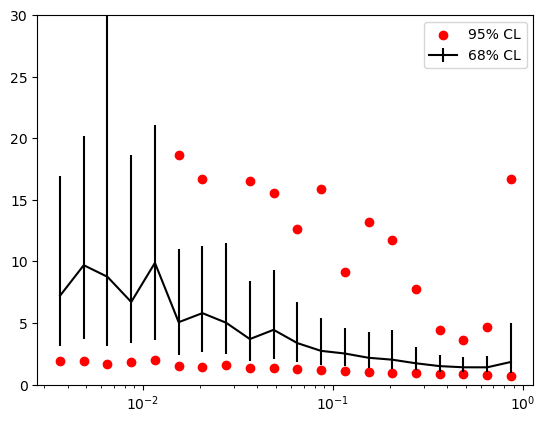

In [23]:
plt.errorbar(xHI_bin_centers, percs[:,2], yerr = [percs[:,2] - percs[:,1], percs[:,3] - percs[:,2]], color = 'k', label = '68% CL')
plt.scatter(xHI_bin_centers, percs[:,0], color = 'r', label = '95% CL')
plt.scatter(xHI_bin_centers, percs[:,4], color = 'r')
plt.ylim(0,30)
plt.xscale('log')
plt.legend()

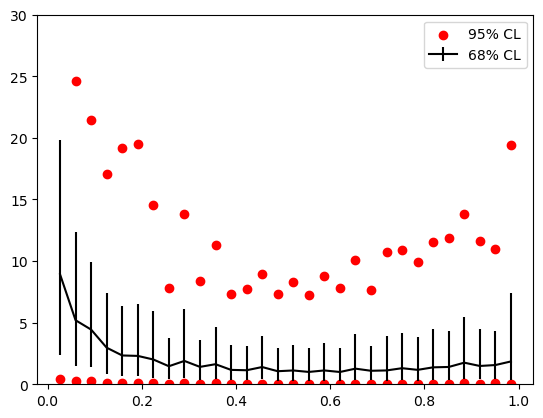

In [22]:
plt.errorbar(xHI_bin_centers, percs[:,2], yerr = [percs[:,2] - percs[:,1], percs[:,3] - percs[:,2]], color = 'k', label = '68% CL')
plt.scatter(xHI_bin_centers, percs[:,0], color = 'r', label = '95% CL')
plt.scatter(xHI_bin_centers, percs[:,4], color = 'r')
plt.ylim(0,30)
plt.legend()

In [23]:
with np.load('/home/dbreitman/CV_PS_denoising/21CMMC/src/py21cmmc/extras.npz') as f:
    k_input_mu = f['k_input_mu']

In [76]:
percs[1,2]

array([[4.56765437, 4.56858683, 5.0333662 , 4.45232844, 4.48638892,
        3.69964635, 3.53276956, 4.04033113, 3.67117321, 3.57874894,
        4.2891736 , 4.50028777, 4.71523285, 5.54415417, 5.82484436,
        6.21707749],
       [3.5382489 , 3.68777084, 4.10655046, 3.79634106, 3.76347935,
        3.39997935, 3.33704722, 3.81174219, 3.40584278, 3.1820451 ,
        3.48787642, 4.02584028, 4.20614672, 4.72413826, 5.12985611,
        5.37135673],
       [3.98615372, 3.91657639, 4.14452553, 3.78960514, 3.98767734,
        3.43708253, 3.49235761, 3.7948159 , 3.64751482, 3.38961577,
        3.56558073, 3.98341787, 4.14969516, 4.62286425, 5.22625613,
        5.37836194],
       [3.88553274, 3.69017124, 3.71281171, 3.68095732, 3.46409512,
        3.70220196, 3.44317651, 3.60896921, 3.06883466, 3.19610894,
        3.47105753, 3.54189587, 3.84443104, 4.44522715, 4.79039049,
        5.09952569],
       [3.84963143, 3.55687106, 3.73573411, 3.5590328 , 3.49072766,
        3.95789421, 3.32479393, 

In [215]:
mask = np.mean(modes, axis = 1) == 0.
mu_1d_err,k, modes1d = ps_2d21d(percs[1,2][~mask], kperp[~mask], kpar, 
                                nbins = k_input_mu, interp=True, 
                                mu = 0.97, 
                                weights=modes[~mask])

In [216]:
mu_1d_err

array([3.68121458, 3.54225981, 3.51128588, 3.7793684 , 4.02950929,
       3.72075958, 3.23379669, 3.37570974, 3.34933151, 3.2909543 ,
       3.38622627, 3.14385478, 3.0087471 , 2.93716181, 2.94429551,
       2.96681244, 2.93741922, 2.92772803, 2.85261367])

In [190]:
delta_1sigma = interp1d(np.round(k,6),mu_1d_err, bounds_error=False, fill_value=np.nan)(np.round(PS_limit_ks,6))

In [107]:
from py21cmfast_tools import ps_2d21d
from scipy.interpolate import interp1d

In [3]:
with np.load('/home/dbreitman/CV_PS_denoising/21CMMC/src/py21cmmc/data/HERA_mock.npz') as ff:
    band = ff['z_bands'][4]
    PS_limit_wfcs = ff['wfband'+str(np.round(band,1))][0]
    kwf_limit_vals = ff['kwfband'+str(np.round(band,1))]*0.6774
    print(band)
    PS_limit_ks = ff['band'+str(np.round(band,1))][0,...,0]*0.6774
    ModelPS_val = ff['band'+str(np.round(band,1))][0,...,1]

9.14571429


In [4]:
kwf_limit_vals.shape, PS_limit_wfcs.shape

((59,), (59, 59))

In [5]:
ModelPS_val = interp1d(np.round(PS_limit_ks,5), ModelPS_val, bounds_error=False)(np.round(kwf_limit_vals,5))

In [6]:
ModelPS_val

array([ 2.1172887 ,  2.86352179,  4.41586268,  4.64315203,  4.63354761,
        4.52729735,  4.42097294,  3.68672021,  2.35348089,  1.92811815,
        2.11245384,  2.69801399,  3.83839656,  4.97798388,  4.84138321,
        4.62516564,  4.99024057,  9.56343238, 14.13343508, 18.70662689,
       17.7000372 , 16.16411253, 14.62925893, 13.10306287, 11.60518832,
       10.1062685 ,  8.60839396,  7.48524908,  9.4531831 , 11.41974479,
       13.38767881, 15.3542405 , 16.61172511, 16.72048751, 16.82932582,
       16.93808822, 17.04692653, 17.19764727, 27.32745804, 37.46433777,
       47.59414855, 57.73102828, 67.86083905, 77.99771878, 77.15802063,
       74.88932008, 72.62220161, 70.35350106, 68.08638259, 65.81768204,
       63.55056356, 61.28344509, 59.01474454, 56.74762607, 54.47892552,
       52.21180705, 49.94310649, 47.67598802, 45.40728747])

In [8]:
ModelPS_val_afterWF_interped.shape

(59,)

In [7]:
ModelPS_val_afterWF_interped = np.dot(PS_limit_wfcs, ModelPS_val)
#Interpolate it back to the ks where I have sensitivity
ModelPS_val_afterWF = interp1d(kwf_limit_vals, ModelPS_val_afterWF_interped, bounds_error=False,fill_value="extrapolate")(PS_limit_ks)

In [225]:
interped_1sigma = interp1d(np.round(PS_limit_ks,6), delta_1sigma)(np.round(kwf_limit_vals,6))
# If we use denoiser
ModelPS_val_1sigma_upper_afterWF = np.dot(
    PS_limit_wfcs,
    ModelPS_val + interped_1sigma,
)
ModelPS_val_1sigma_lower_afterWF = np.dot(
    PS_limit_wfcs,
    ModelPS_val - interped_1sigma,
)

# The upper and lower errors are very similar usually, so we can just take the mean and use that.
mean_err = np.nanmean(
    [
        ModelPS_val_1sigma_upper_afterWF
        - ModelPS_val_afterWF_interped,
        ModelPS_val_afterWF_interped
        - ModelPS_val_1sigma_lower_afterWF,
    ],
    axis=0,
)

In [232]:
mean_err_final = interp1d(kwf_limit_vals, mean_err,bounds_error=False,fill_value="extrapolate")(PS_limit_ks)

In [229]:
mean_err

array([2.47228246, 3.0913187 , 3.49573577, 3.74439114, 3.79157305,
       3.6709853 , 3.49818522, 3.41879536, 3.34464557, 3.33939872,
       3.3490833 , 3.34006211, 3.32709255, 3.32373234, 3.31928403,
       3.33417895, 3.33665584, 3.2995258 , 3.27796536, 3.21211456,
       3.14495488, 3.08738163, 3.04171392, 3.03608155, 3.00440315,
       2.98167663, 2.9605682 , 2.94429783, 2.94716287, 2.94023514,
       2.94100393, 2.94324952, 2.94662891, 2.95011073, 2.95141441,
       2.95555462, 2.96028923, 2.96294046, 2.96106258, 2.95951105,
       2.95564901, 2.94960691, 2.94308253, 2.93700624, 2.93630364,
       2.9303073 , 2.92391517, 2.91685563, 2.90911783, 2.90839194,
       2.90185752, 2.89575968, 2.88893749, 2.88070886, 2.87937362,
       2.87206627, 2.86729656, 2.86165364, 2.85632866])

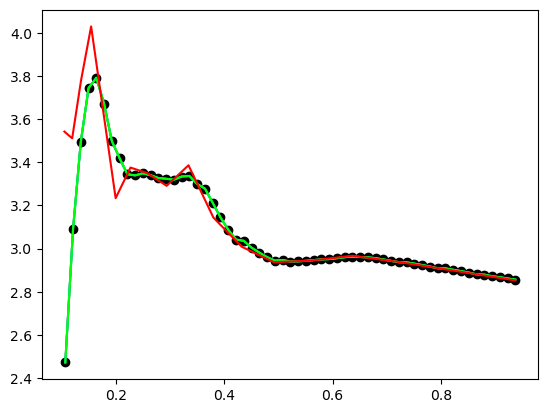

In [237]:
plt.plot(kwf_limit_vals,mean_err, color = 'k', marker = 'o')
plt.plot(kwf_limit_vals,ModelPS_val_1sigma_upper_afterWF
        - ModelPS_val_afterWF_interped, color = 'cyan')
plt.plot(kwf_limit_vals,ModelPS_val_afterWF_interped
        - ModelPS_val_1sigma_lower_afterWF, color = 'lime')
plt.plot(PS_limit_ks,delta_1sigma, color = 'r')
#plt.plot(PS_limit_ks,mean_err_final, color = 'lime')

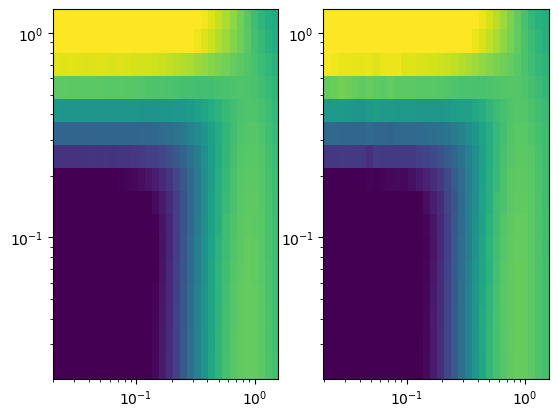

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
vmin = 200
vmax = 1000
axs[0].pcolormesh(kperp, kpar, pred0['ypred'][1].T, vmin=vmin, vmax=vmax)
axs[1].pcolormesh(kperp, kpar, truth[1].T, vmin=vmin, vmax=vmax)
axs[0].loglog()
axs[1].loglog()
plt.show()

In [23]:
abs((pred0['ypred'] - truth)/truth)[1]

array([[3.17546725e-02, 4.79535162e-02, 7.03249350e-02, 7.39560649e-02,
        8.46829116e-02, 1.77569631e-02, 2.13599931e-02, 2.63347849e-02,
        5.19006439e-02, 3.06285899e-02, 3.02343853e-02, 8.74928106e-03,
        7.04832608e-03, 2.62650009e-02, 2.02330500e-02, 1.85527578e-02],
       [1.71669461e-02, 2.62438469e-02, 5.57227693e-02, 6.81556612e-02,
        7.90930018e-02, 5.10866754e-02, 2.48103458e-02, 2.40687430e-02,
        3.64476107e-02, 4.29814160e-02, 2.02337094e-02, 1.38734691e-02,
        1.97953694e-02, 2.08376534e-02, 1.53238662e-02, 2.66024061e-02],
       [2.03938573e-03, 1.29014542e-02, 4.50515859e-02, 5.58964722e-02,
        7.76832774e-02, 7.78927281e-02, 3.31996568e-02, 3.39735858e-02,
        1.59522202e-02, 5.32512143e-02, 1.29212225e-02, 2.14215424e-02,
        3.56547311e-02, 1.03127975e-02, 1.47362147e-02, 3.23269553e-02],
       [3.04222740e-02, 2.85089482e-02, 3.85754816e-02, 5.05498014e-02,
        7.10226893e-02, 6.90981299e-02, 3.83526571e-02, 3.801

/var/tmp/pbs.313004.pbs01/ipykernel_144980/3569409861.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(abs((pred0['ypred'] - truth)/truth)*100., axis = (-1,-2))


array([       nan,  1.9588645,  1.2528725, ..., 11.577425 ,  1.6930029,
        2.7434363], dtype=float32)

In [3]:
seeds.shape

(199, 40, 32, 16)

In [6]:
print(xhi[0,0:3])

[0.05762584 0.13385727 0.23274855]


In [7]:
out = Denoiser().predict(seeds[0,0:3], kperp, kpar, global_Tb=tb[0,0:3], global_xHI = xhi[0,0:3], N=10)

(3, 2)


Sampling :   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
out.mean_delta.shape

(3, 32, 16)

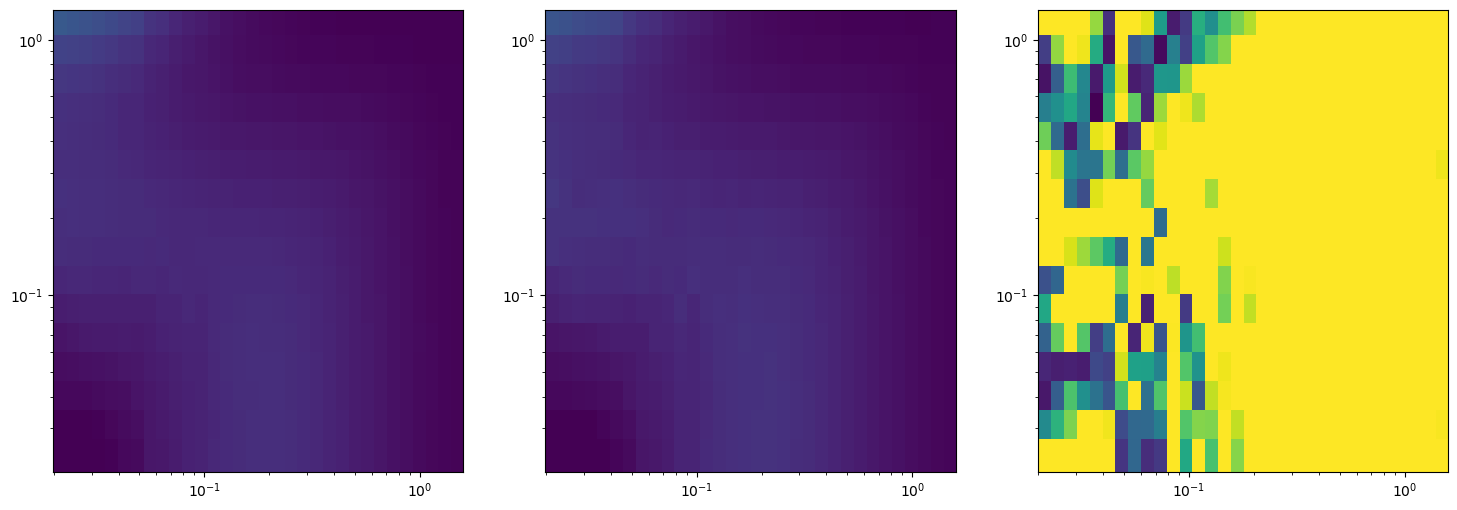

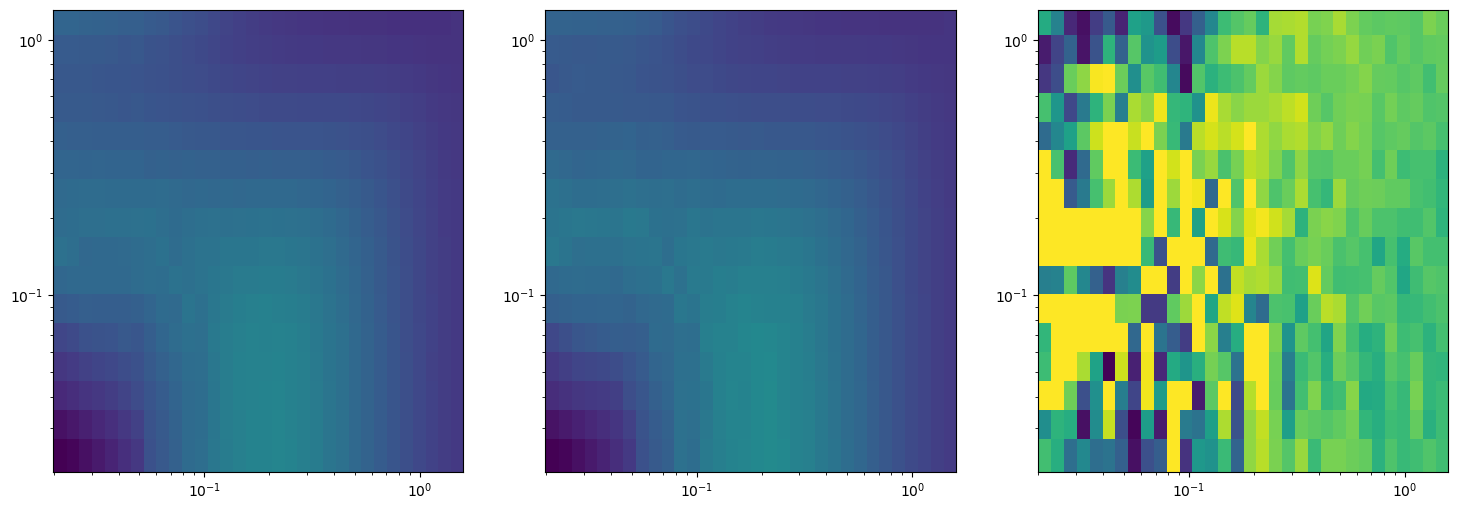

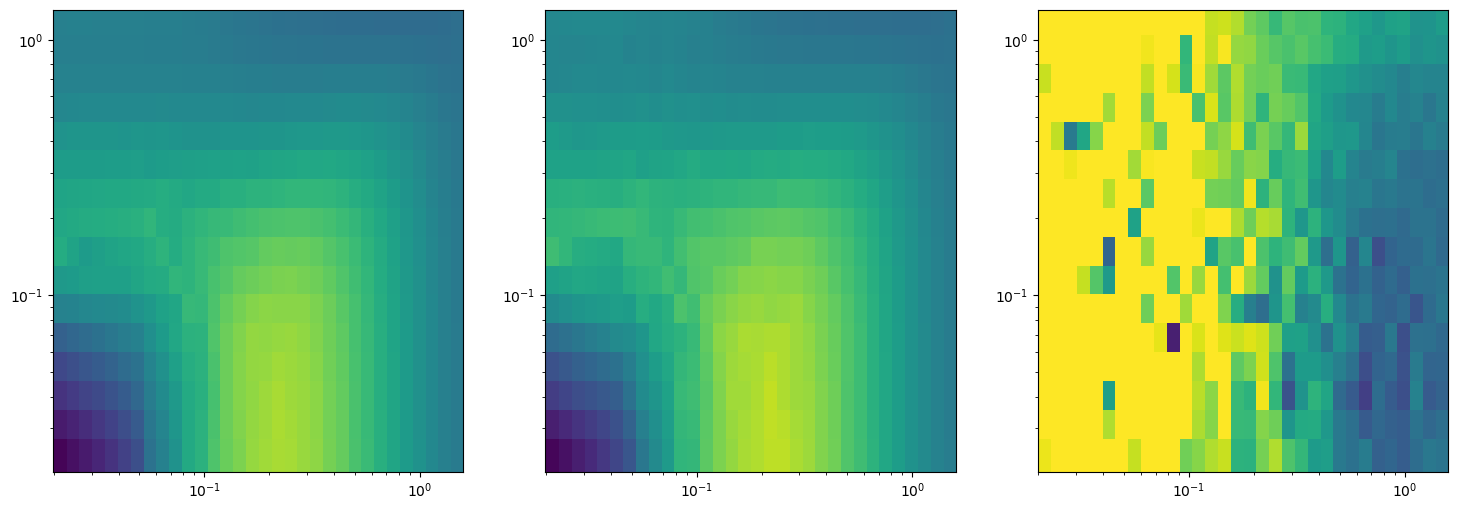

In [13]:
vmin = 0.5
vmax = 6
for i in range(out.mean_delta.shape[0]):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (18,6))
    axs[0].pcolormesh(kperp, kpar, out.mean_delta[i].T, vmin=vmin, vmax=vmax)
    axs[1].pcolormesh(kperp, kpar, mean[0,i].T, vmin=vmin, vmax=vmax)
    axs[2].pcolormesh(kperp, kpar, abs(100*(mean[0,i] - out.mean_delta[i])/mean[0,i]).T, vmin = 0, vmax = 4)
    axs[0].loglog()
    axs[1].loglog()
    axs[2].loglog()
    plt.show()

In [24]:
import numpy as np
f = np.load('/home/dbreitman/CV_PS_denoising/cAE_wTbz/Aug/score_based/results2/historypt1.npz')

In [28]:
dict(f).keys()

dict_keys(['loss', 'val_loss', 'lr', 'mu_FE', 'noisy_mean', 'noisy_std', 'mean_mean', 'mean_std', 'std_std', 'std_mean', 'Tb_mean', 'Tb_scale', 'Tb_std', 'param_labels', 'param_limits'])

In [34]:
csts = {}
csts['noisy_mean'] = f['noisy_mean']
csts['noisy_std'] = f['noisy_std']
csts['mean_mean'] = f['mean_mean']
csts['mean_std'] = f['mean_std']
csts['Tb_mean'] = f['Tb_mean']
csts['Tb_std'] = f['Tb_std']
csts['Tb_scale'] = f['Tb_scale']
csts['param_labels'] = f['param_labels']
csts['param_limits'] = f['param_limits']
csts['kperp'] = kperp
csts['kpar'] = kpar
csts['Nmodes'] = Nmodes
csts['h'] = 0.6774
# This is to avoid issues with the interpolation. I don't want to extrapolate
# Last bin center is ~0.91. We can just use the error at 0.91 until 1.0.
final_bins = xHI_bin_centers.copy()
final_bins[-1] = 1.0
csts['err_xHI_bins'] = final_bins
csts['median_err_on_mean_vs_xHI'] = np.nanmean([percs[:,2] - percs[:,1], percs[:,3] - percs[:,2]], axis = 0)#[xHI val, kperp, kpar]
csts['median_err_on_mean_2D'] = np.median(all_mu_fes, axis = 0)

In [35]:
np.savez('constants', **csts)

In [63]:
final_bins = xHI_bin_centers.copy()
final_bins[-1] = 1.0